The purpose of this notebook is two-fold. In it, I aim to:
1. Reproduce the MNL model used in "Brownstone, Davide and Train, Kenneth (1999). 'Forecasting new product penetration with flexible substitution patterns'. Journal of Econometrics 89: 109-129." (p. 121).
2. 'Check' the MNL model for lack-of-fit between observable features of the data and predictions from the model.

In [1]:
import sys
from collections import OrderedDict

import scipy.stats
import pandas as pd
import numpy as np

sys.path.insert(0, '/Users/timothyb0912/Documents/pylogit')
import pylogit as pl

sys.path.insert(0, '/Users/timothyb0912/Documents/stat241a/final_project/')
import predictive_viz as viz

%matplotlib inline

/Users/timothyb0912/anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


# Load the car data

In [2]:
car_df = pd.read_csv("../data/car_long_format.csv")

# Create the necessary variables

In [3]:
car_df.head().T

0        1         2         3         4
obs_id                       1        1         1         1         1
alt_id                       1        2         3         4         5
choice                       1        0         0         0         0
college                      0        0         0         0         0
hsg2                         0        0         0         0         0
coml5                        0        0         0         0         0
vehicle_size                 3        3         2         2         3
acceleration                 4        4         6         6       2.5
price_over_log_income  4.17534  4.17534   4.81771   4.81771   5.13889
top_speed                   95       95       110       110       140
fuel_type                  cng      cng  electric  electric  gasoline
luggage_space              0.7      0.7         1         1         1
body_type                  van   regcar       van   stwagon       van
cents_per_mile               4        4         6         6         8
station_availability       0.1      0.1       0.3       0.3         1
range                      250      250       400       400       250
pollution                  0.6      0.6      0.25      0.25       0.5

In [4]:
# Create the 'big_enough' variable
car_df['big_enough'] =\
    (car_df['hsg2'] & (car_df['vehicle_size'] == 3)).astype(int)

# Determine the type of car
car_df['sports_utility_vehicle'] =\
    (car_df['body_type'] == 'sportuv').astype(int)

car_df['sports_car'] =\
    (car_df['body_type'] == 'sportcar').astype(int)
    
car_df['station_wagon'] =\
    (car_df['body_type'] == 'stwagon').astype(int)

car_df['truck'] =\
    (car_df['body_type'] == 'truck').astype(int)

car_df['van'] =\
    (car_df['body_type'] == 'van').astype(int)

# Determine the car's fuel usage
car_df['electric'] =\
    (car_df['fuel_type'] == 'electric').astype(int)

car_df['compressed_natural_gas'] =\
    (car_df['fuel_type'] == 'cng').astype(int)

car_df['methanol'] =\
    (car_df['fuel_type'] == 'methanol').astype(int)

# Determine if this is an electric vehicle with a small commute
car_df['electric_commute_lte_5mi'] =\
    (car_df['electric'] & car_df['coml5']).astype(int)

# See if this is an electric vehicle for a college educated person
car_df['electric_and_college'] =\
    (car_df['electric'] & car_df['college']).astype(int)

# See if this is a methanol vehicle for a college educated person
car_df['methanol_and_college'] =\
    (car_df['methanol'] & car_df['college']).astype(int)
    
# Scale the range and acceleration variables
car_df['range_over_100'] = car_df['range'] / 100.0
car_df['acceleration_over_10'] = car_df['acceleration'] / 10.0
car_df['top_speed_over_100'] = car_df['top_speed'] / 100.0
car_df['vehicle_size_over_10'] = car_df['vehicle_size'] / 10.0
car_df['tens_of_cents_per_mile'] = car_df['cents_per_mile'] / 10.0

In [5]:
car_df.loc[car_df.choice == 1, 'fuel_type'].value_counts()

electric    1491
gasoline    1310
cng         1062
methanol     791
Name: fuel_type, dtype: int64

# Create the utility specification

In [6]:
car_mnl_spec, car_mnl_names = OrderedDict(), OrderedDict()

cols_and_display_names =\
    [('price_over_log_income', 'Price over log(income)'),
     ('range_over_100', 'Range (units: 100mi)'),
     ('acceleration_over_10', 'Acceleration (units: 0.1sec)'),
     ('top_speed_over_100', 'Top speed (units: 0.01mph)'),
     ('pollution', 'Pollution'),
     ('vehicle_size_over_10', 'Size'),
     ('big_enough', 'Big enough'),
     ('luggage_space', 'Luggage space'),
     ('tens_of_cents_per_mile', 'Operation cost'),
     ('station_availability', 'Station availability'),
     ('sports_utility_vehicle', 'Sports utility vehicle'),
     ('sports_car', 'Sports car'),
     ('station_wagon', 'Station wagon'),
     ('truck', 'Truck'),
     ('van', 'Van'),
     ('electric', 'EV'),
     ('electric_commute_lte_5mi', 'Commute < 5 & EV'),
     ('electric_and_college', 'College & EV'),
     ('compressed_natural_gas', 'CNG'),
     ('methanol', 'Methanol'),
     ('methanol_and_college', 'College & Methanol')]
    
for col, display_name in cols_and_display_names:
    car_mnl_spec[col] = 'all_same'
    car_mnl_names[col] = display_name


# Estimate the MNL model

In [7]:
# Initialize the mnl model
car_mnl = pl.create_choice_model(data=car_df,
                                 alt_id_col='alt_id',
                                 obs_id_col='obs_id',
                                 choice_col='choice',
                                 specification=car_mnl_spec,
                                 model_type='MNL',
                                 names=car_mnl_names)

# Create the initial variables for model estimation
num_vars = len(car_mnl_names)
initial_vals = np.zeros(num_vars)

# Estimate the mnl model
fit_vals = car_mnl.fit_mle(initial_vals,
                           method='L-BFGS-B',
                           just_point=True)['x']
car_mnl.fit_mle(fit_vals, method='BFGS')

# Look at the estimation results
car_mnl.get_statsmodels_summary()

/Users/timothyb0912/anaconda/lib/python2.7/site-packages/scipy/optimize/_minimize.py:385: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  RuntimeWarning)


Log-likelihood at zero: -8,338.8486
Initial Log-likelihood: -7,394.6769
Estimation Time for Point Estimation: 0.11 seconds.
Final log-likelihood: -7,394.6247


/Users/timothyb0912/anaconda/lib/python2.7/site-packages/scipy/optimize/_minimize.py:385: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Multinomial Logit Model Regression Results                    
===================================================================================
Dep. Variable:                      choice   No. Observations:                4,654
Model:             Multinomial Logit Model   Df Residuals:                    4,633
Method:                                MLE   Df Model:                           21
Date:                     Sat, 13 Jan 2018   Pseudo R-squ.:                   0.113
Time:                             15:47:21   Pseudo R-bar-squ.:               0.111
AIC:                            14,831.249   Log-Likelihood:             -7,394.625
BIC:                            14,966.605   LL-Null:                    -8,338.849
================================================================================================
                                   coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------------
Price over log(income)          -0.1855      0.027     -6.801      0.000        -0.239    -0.132
Range (units: 100mi)             0.3503      0.027     13.060      0.000         0.298     0.403
Acceleration (units: 0.1sec)    -0.7187      0.111     -6.489      0.000        -0.936    -0.502
Top speed (units: 0.01mph)       0.2626      0.081      3.245      0.001         0.104     0.421
Pollution                       -0.4441      0.102     -4.366      0.000        -0.644    -0.245
Size                             0.9307      0.317      2.937      0.003         0.310     1.552
Big enough                       0.1397      0.077      1.809      0.070        -0.012     0.291
Luggage space                    0.4916      0.191      2.575      0.010         0.117     0.866
Operation cost                  -0.7663      0.076    -10.111      0.000        -0.915    -0.618
Station availability             0.4116      0.097      4.259      0.000         0.222     0.601
Sports utility vehicle           0.8191      0.141      5.823      0.000         0.543     1.095
Sports car                       0.6363      0.148      4.293      0.000         0.346     0.927
Station wagon                   -1.4357      0.062    -23.126      0.000        -1.557    -1.314
Truck                           -1.0160      0.049    -20.737      0.000        -1.112    -0.920
Van                             -0.7999      0.048    -16.776      0.000        -0.893    -0.706
EV                               0.3190      0.105      3.028      0.002         0.112     0.525
Commute < 5 & EV                -0.0175      0.078     -0.225      0.822        -0.170     0.135
College & EV                     0.2267      0.089      2.551      0.011         0.053     0.401
CNG                              0.3430      0.092      3.718      0.000         0.162     0.524
Methanol                        -0.0663      0.165     -0.402      0.688        -0.389     0.257
College & Methanol               0.4188      0.109      3.859      0.000         0.206     0.632
================================================================================================
"""

# Replication Results

The original modeling results cannot be replicated. When using the same model specification as the original authors, my coefficient estimates are different than those obtained in the original study.

The major differences seem to be with the various fuel type variables and their interactions. I am not sure why.

Using the coefficient estimates from the paper does not work either.

My suspicion is that my variables are not defined the same way as in the paper.

### See if paper results can be replicated:

In [8]:
paper_vals =\
    np.array([-0.185,
               0.350,
              -0.716,
               0.261,
              -0.444,
               0.935,
               0.143,
               0.501,
              -0.768,
               0.413,
               0.820,
               0.637,
              -1.437,
              -1.017,
              -0.799,
              -0.179,
               0.198,
               0.443,
               0.345,
               0.313,
               0.228])
    
np.log(car_mnl.predict(car_df,
                       param_list=[paper_vals, None, None, None],
                       return_long_probs=False,
                       choice_col='choice')).sum()

-7458.0897811913037

The answer appears to be no.

# MNL Model Checking

In [9]:
# Simulate values from the sampling distribution of coefficients
cov_matrix = np.linalg.inv(-1 * car_mnl.hessian)
mnl_sampling_dist =\
    scipy.stats.multivariate_normal(mean=car_mnl.params.values,
                                    cov=cov_matrix)

In [10]:
# Take Draws from the sampling distribution
num_draws = 500
simulated_coefs = mnl_sampling_dist.rvs(num_draws)
simulated_coefs.shape

(500, 21)

In [11]:
# Predict the model probabilities
simulated_probs =\
    car_mnl.predict(car_df,
                    param_list=[simulated_coefs.T, None, None, None])

# Simulate y from the sampling distribution
likelihood_sim_y =\
    viz.simulate_choice_vector(simulated_probs,
                               car_df['obs_id'].values,
                               rseed=1122018)

Simulating Choices: 100%|██████████| 4654/4654 [00:00<00:00, 8525.57it/s]


## Price/log(income)

Calculating CDFs: 100%|██████████| 100/100 [00:00<00:00, 311.58it/s]
/Users/timothyb0912/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
Calculating KDEs: 100%|██████████| 100/100 [00:00<00:00, 156.01it/s]


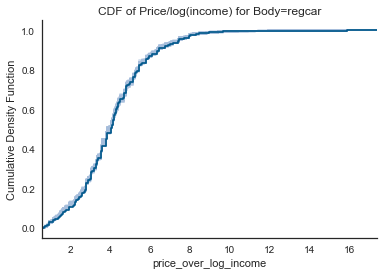

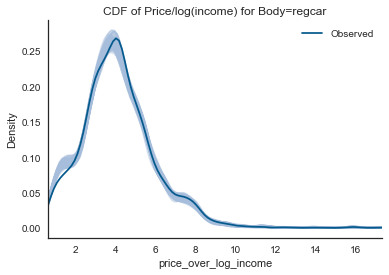

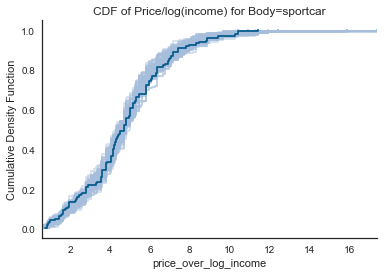

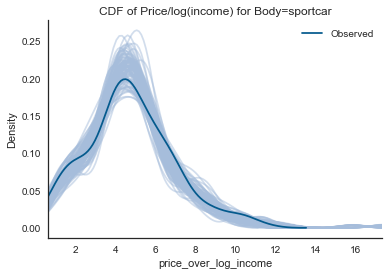

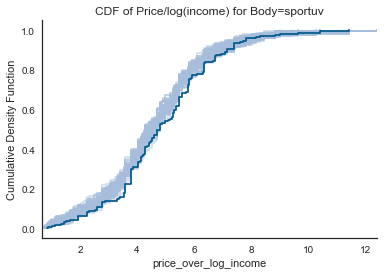

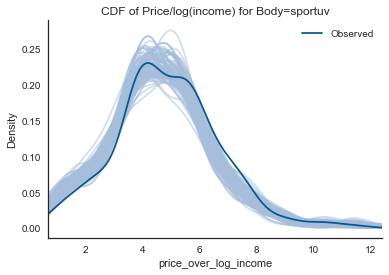

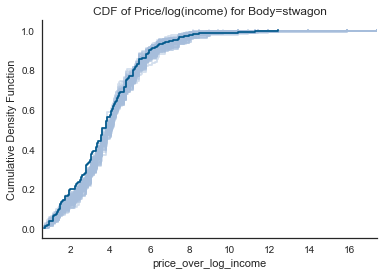

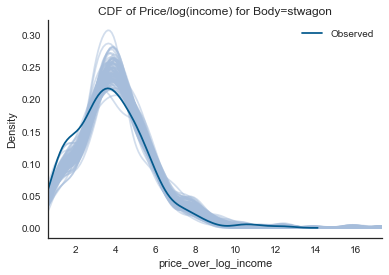

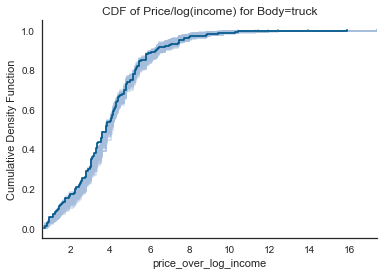

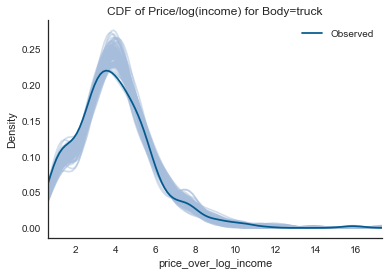

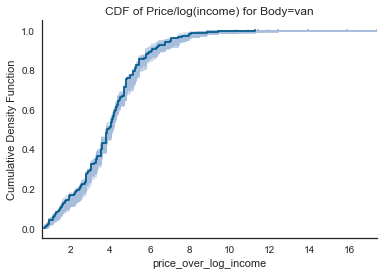

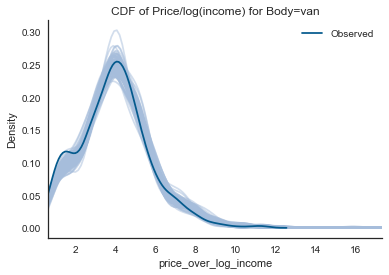

In [12]:
# Check the price variable for all of the various modes.
for body in np.sort(car_df.body_type.unique()):
    filter_row = car_df.body_type == body
    
    current_title = 'CDF of Price/log(income) for Body={}'
    
    viz.plot_simulated_cdf_traces(likelihood_sim_y,
                                  car_df,
                                  filter_row,
                                  'price_over_log_income',
                                  'choice',
                                  title=current_title.format(body))
    
    title_2 = 'KDE of Price/log(income) for Body={}'
    viz.plot_simulated_kde_traces(likelihood_sim_y,
                                  car_df,
                                  filter_row,
                                  'price_over_log_income',
                                  'choice',
                                  title=current_title.format(body))
    

From the plots above, we can see that having a single price variable is not sufficient to capture the observed relationships between price and chosen body type of one's vehicle. In particular, we frequently:

1. overpredict the choice of SUV as a function of price.
2. underpredict the choice of station wagon, truck, and van as a function of price.

Calculating KDEs: 100%|██████████| 100/100 [00:00<00:00, 165.49it/s]


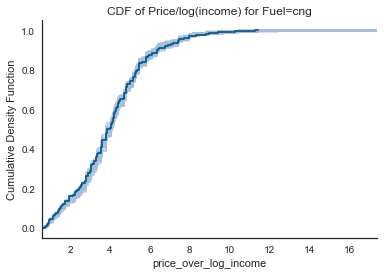

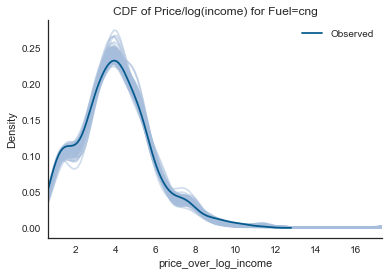

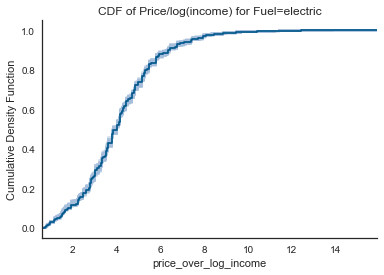

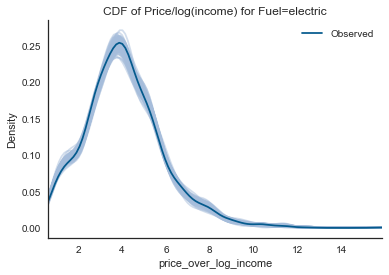

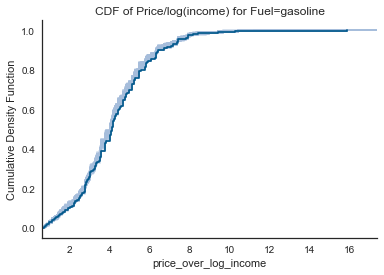

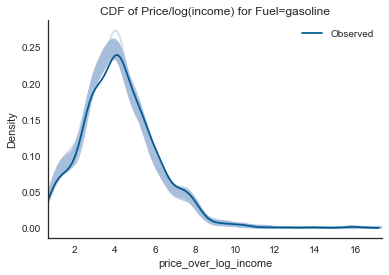

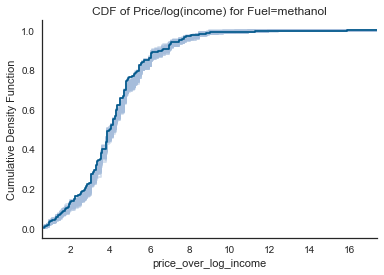

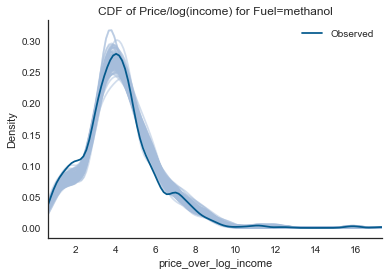

In [13]:
# Check the price variable for all of the various modes.
for fuel in np.sort(car_df.fuel_type.unique()):
    filter_row = car_df.fuel_type == fuel
    current_title = 'CDF of Price/log(income) for Fuel={}'
    
    viz.plot_simulated_cdf_traces(likelihood_sim_y,
                                  car_df,
                                  filter_row,
                                  'price_over_log_income',
                                  'choice',
                                  title=current_title.format(fuel))
    
    title_2 = 'KDE of Price/log(income) for Fuel={}'
    viz.plot_simulated_kde_traces(likelihood_sim_y,
                                  car_df,
                                  filter_row,
                                  'price_over_log_income',
                                  'choice',
                                  title=current_title.format(fuel))

From the plots above we can see that our model does not adequately capture the relationship between price/log(income) and fuel type.

## Range

/Users/timothyb0912/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


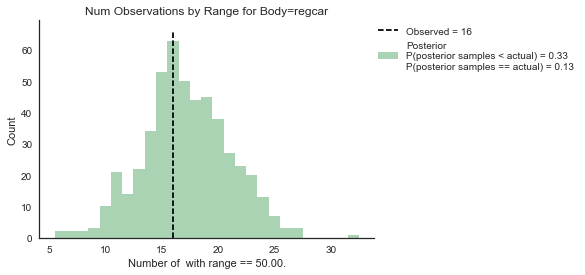

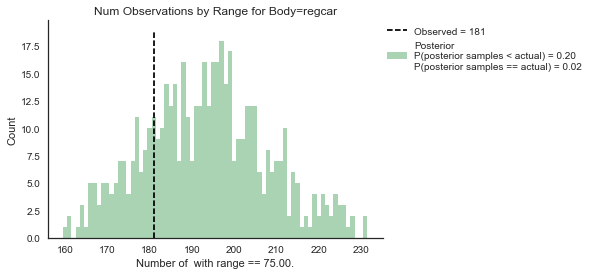

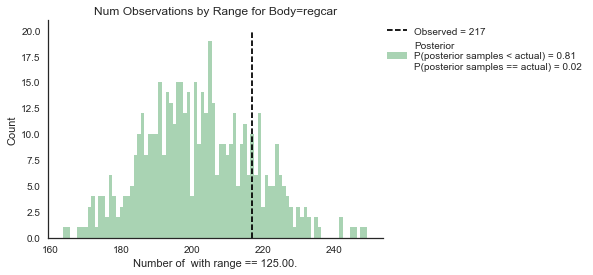

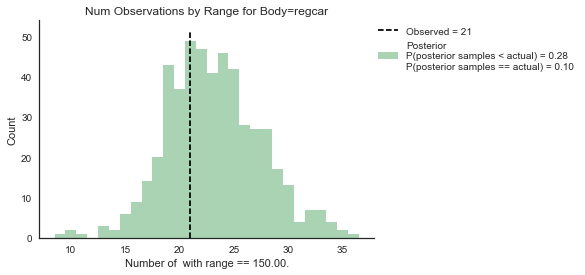

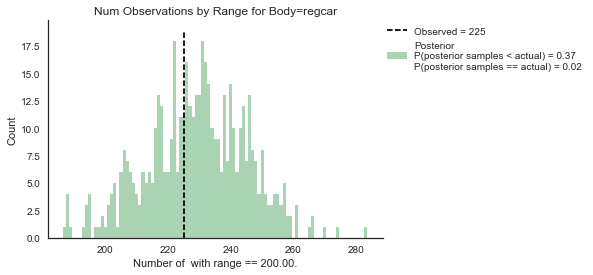

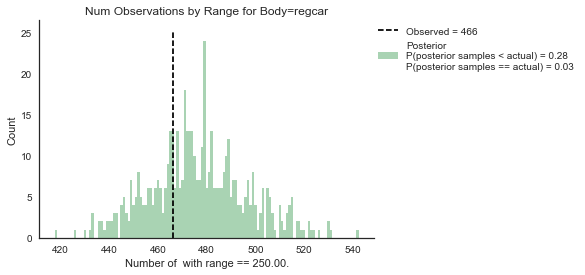

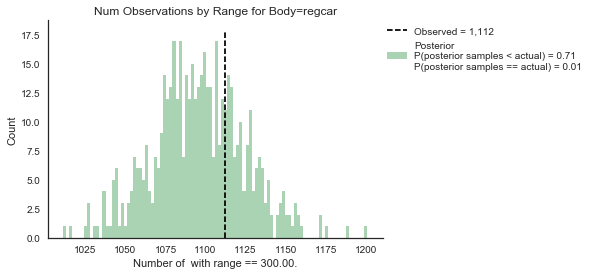

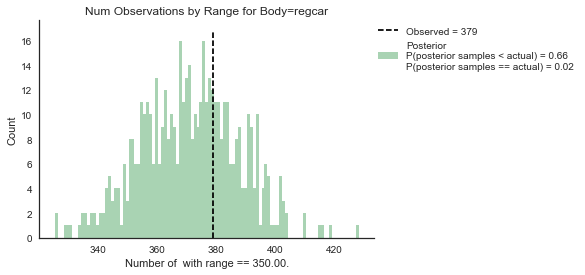

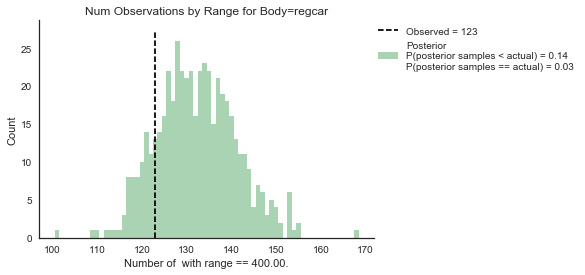

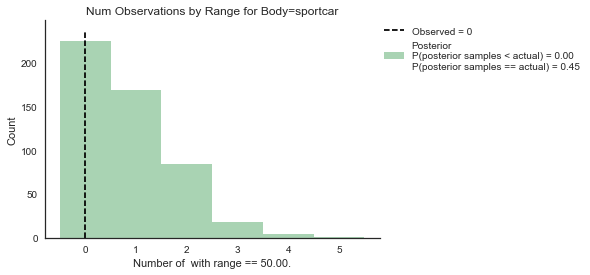

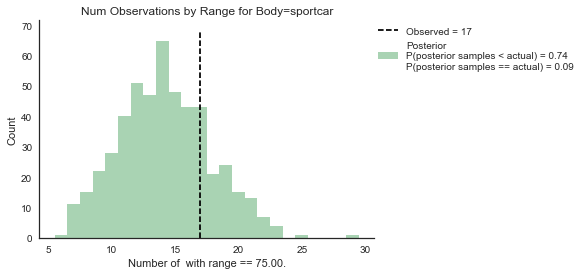

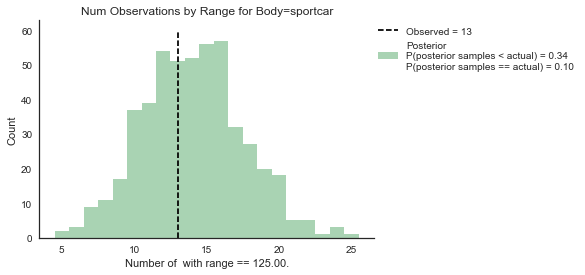

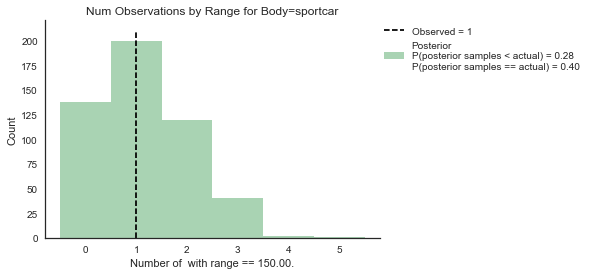

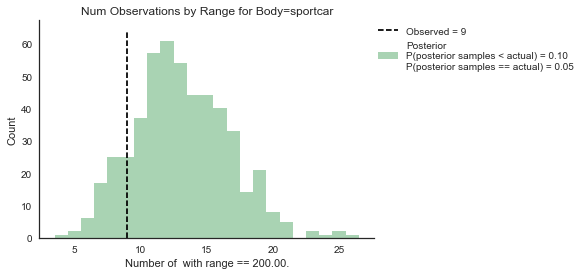

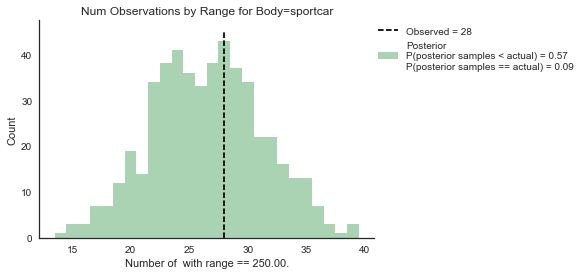

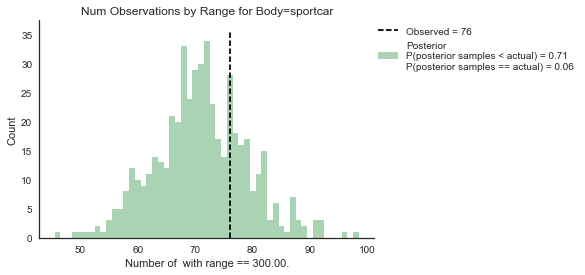

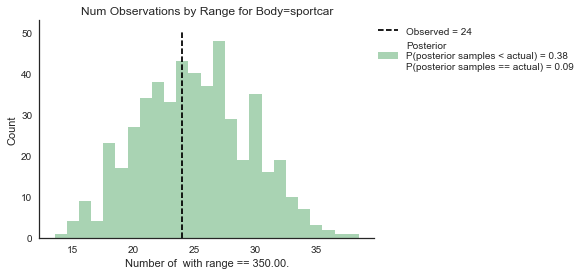

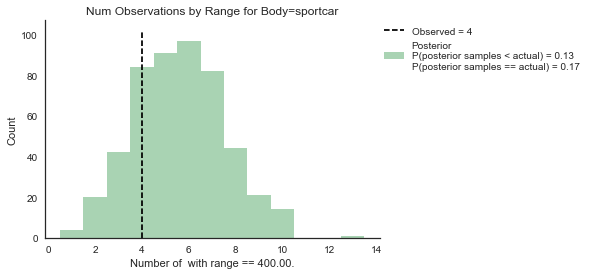

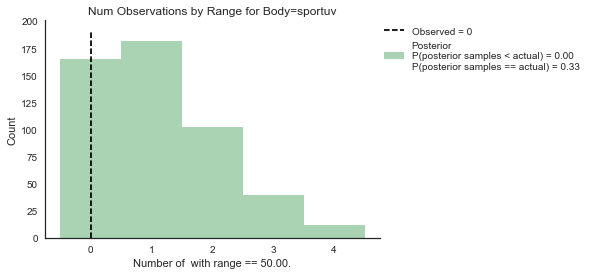

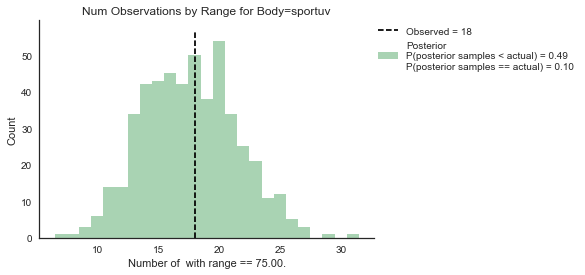

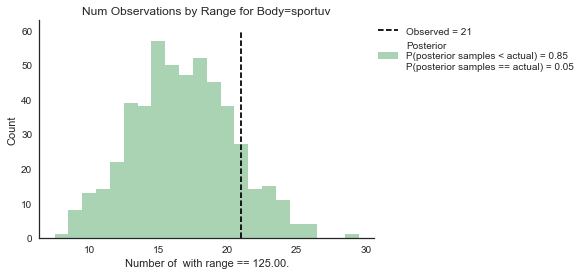

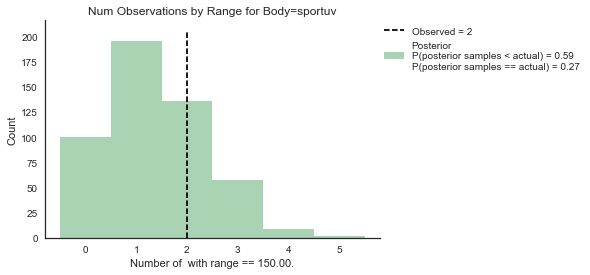

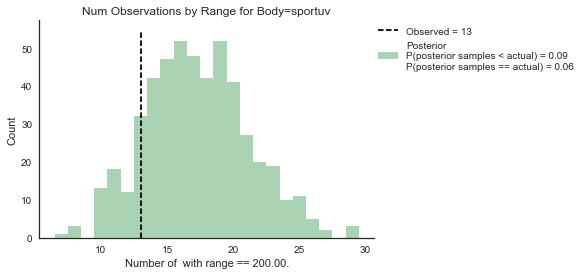

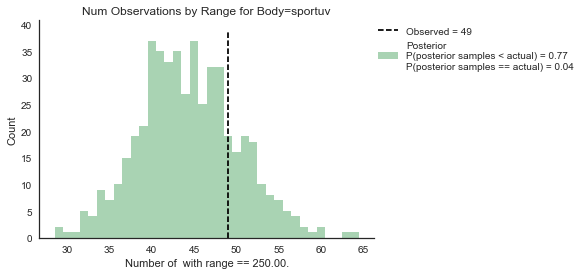

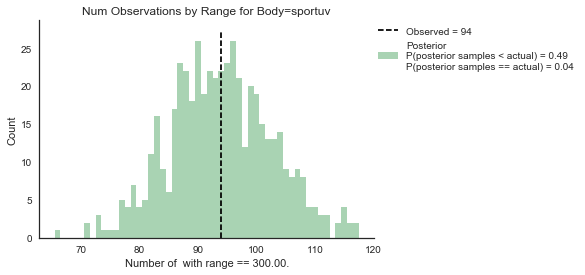

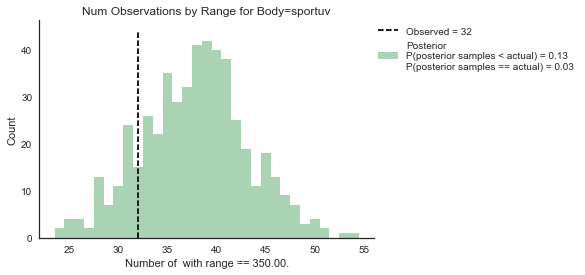

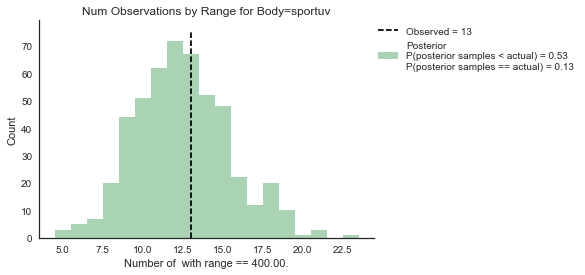

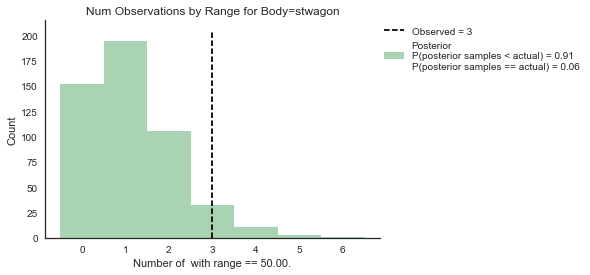

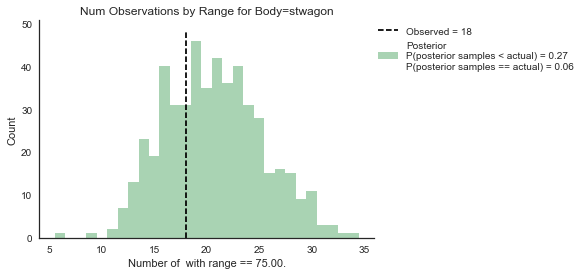

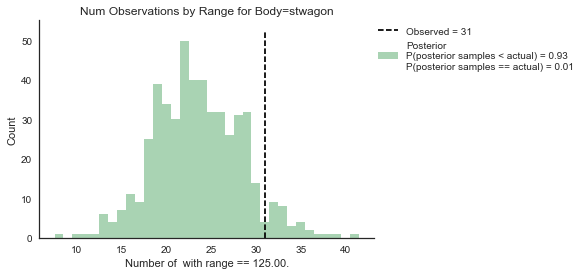

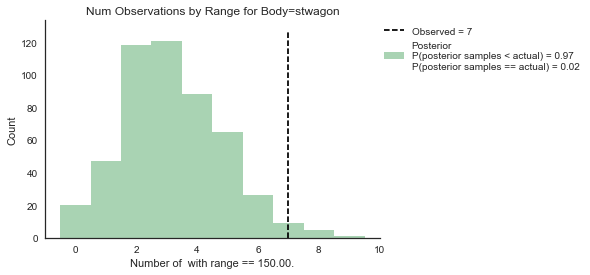

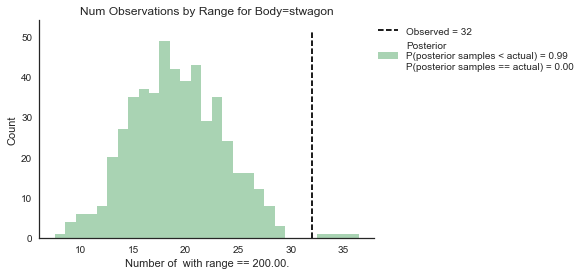

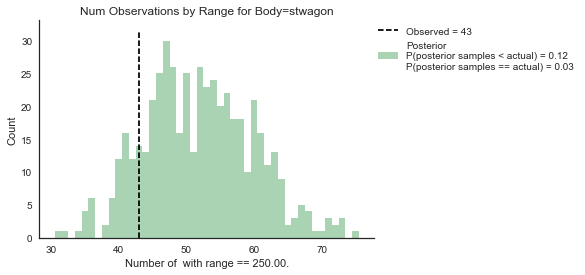

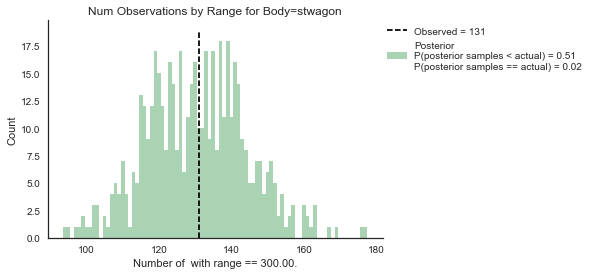

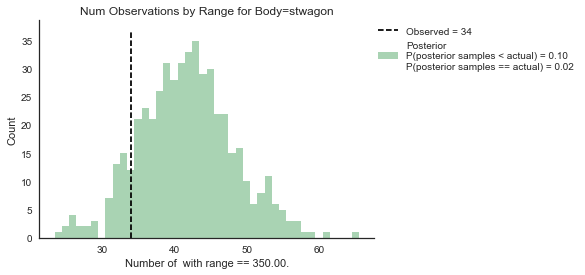

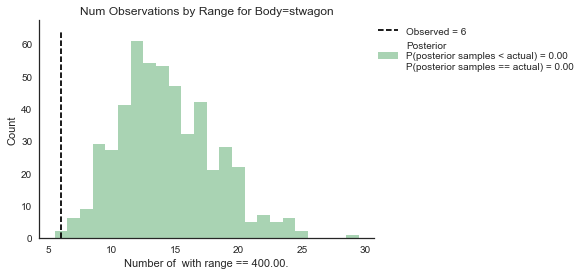

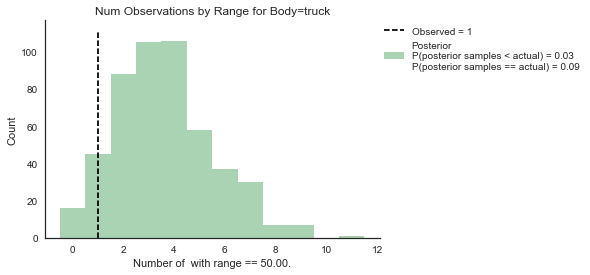

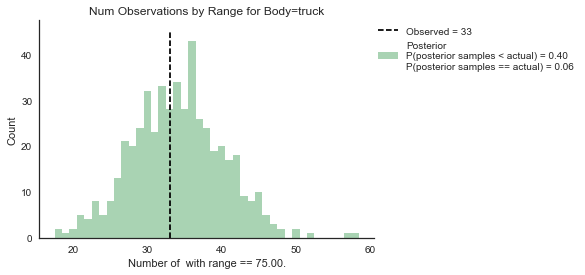

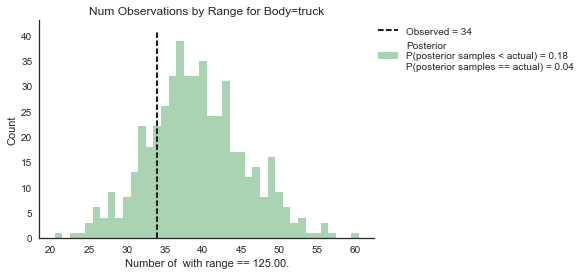

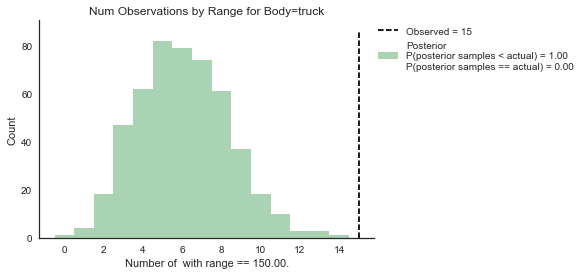

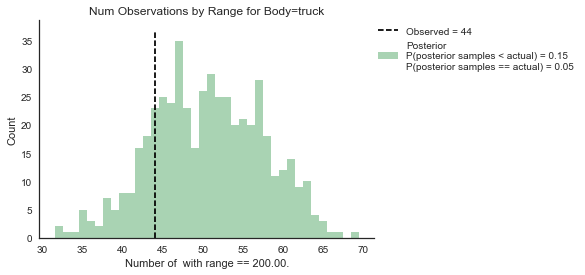

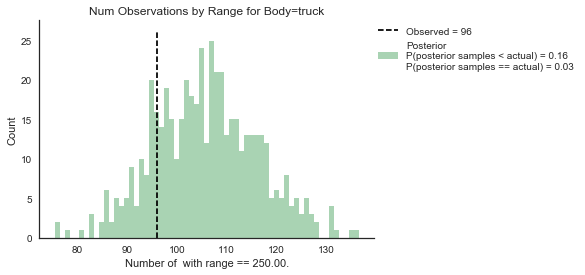

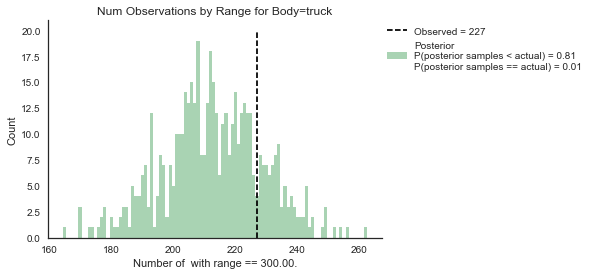

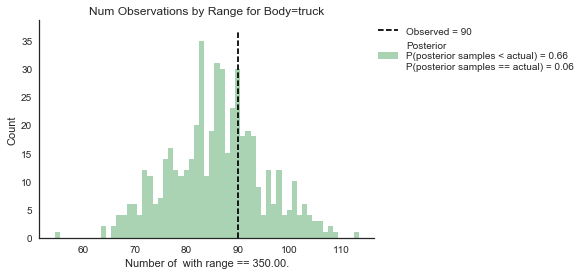

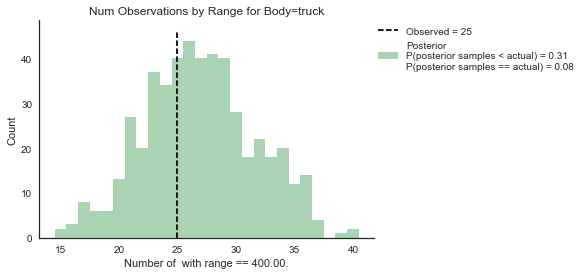

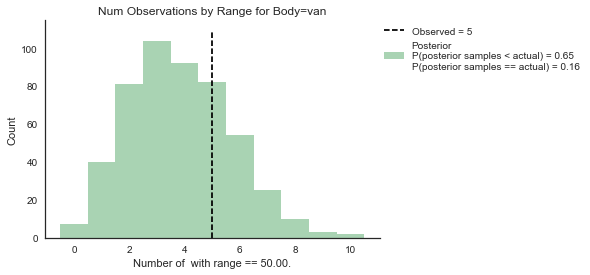

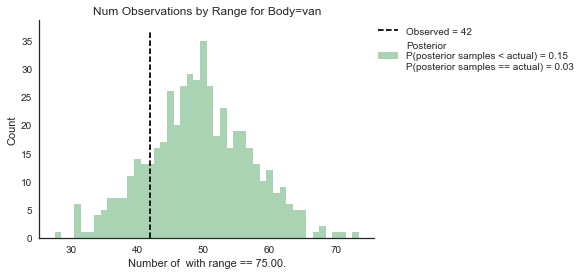

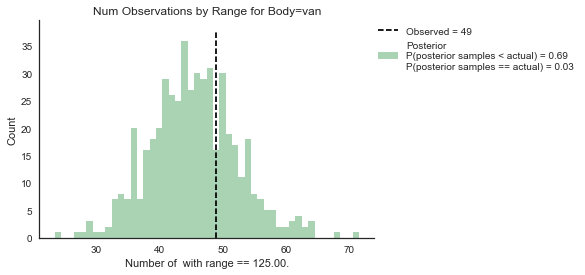

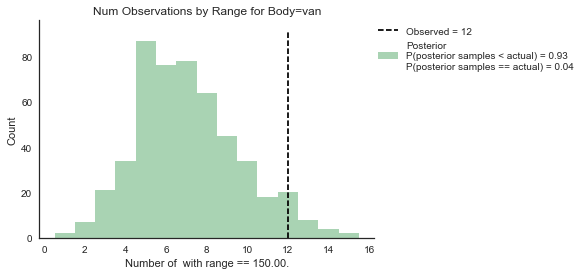

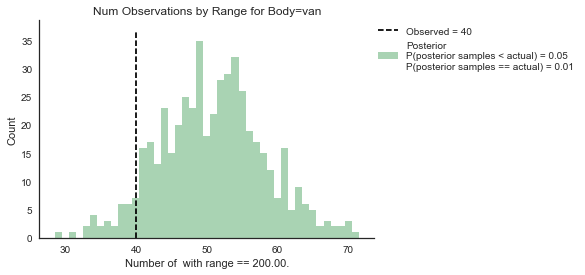

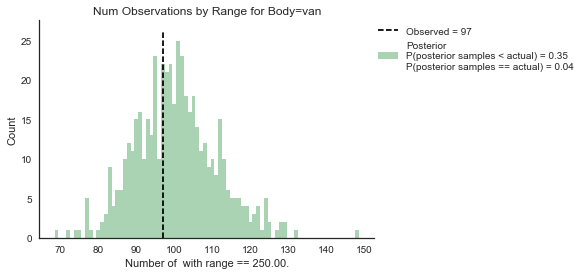

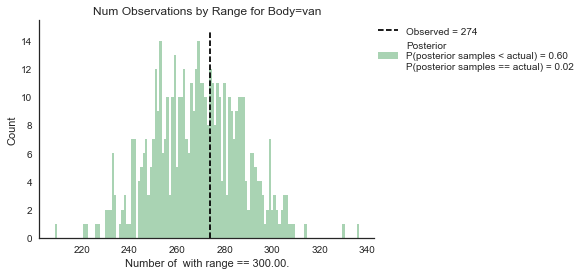

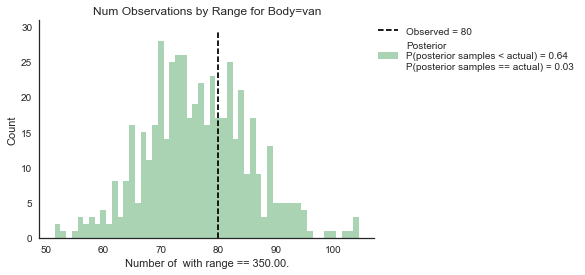

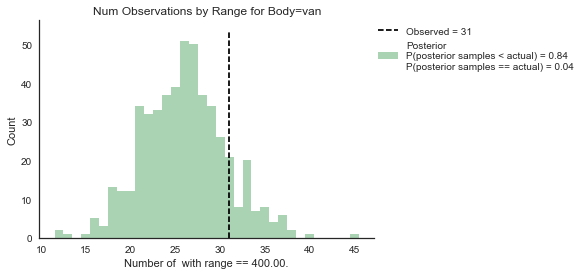

In [14]:
# Check the price variable for all of the various modes.
for body in np.sort(car_df.body_type.unique()):
    filter_row = car_df.body_type == body
    
    current_title = 'Num Observations by Range for Body={}'
    
    viz.plot_categorical_predictive_densities(
        car_df,
        None,
        likelihood_sim_y,
        'range',
        filter_row,
        car_mnl.choices,
        title=current_title.format(body))
    

In [15]:
car_df.loc[car_df.choice == 1, 'range'].value_counts()

300    1914
250     779
350     639
125     365
200     363
75      309
400     202
150      58
50       25
Name: range, dtype: int64

As seen above, range is a categorical variable.

From examining the plots of the simulated y-values from the sampling distribution, we can see that our fitted model leads to severe misfit between various features of the range variable:

1. we underpredict the number of station wagons with range in {50, 125, 150, 200}
2. we overpredict the number of station wagons with range in {250, 350, 400}.
3. we underpredict the number of trucks with range in {150}.
4. we overpredict the number of trucks with range in {50}.
5. we underpredict the number of vans with range in {150}.
6. we overpredict the number of vans with range in {200}.

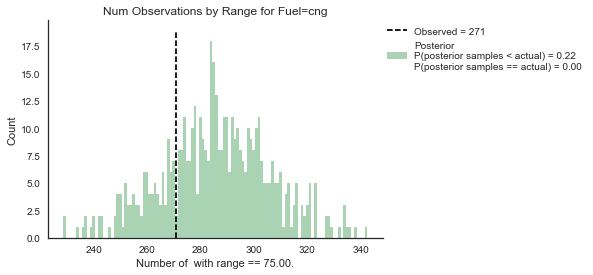

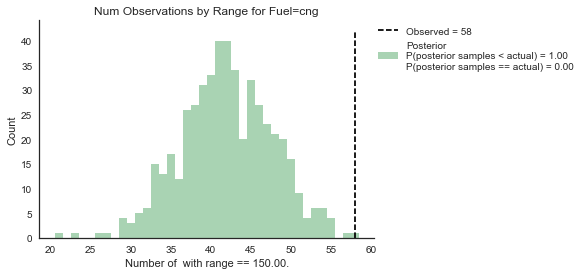

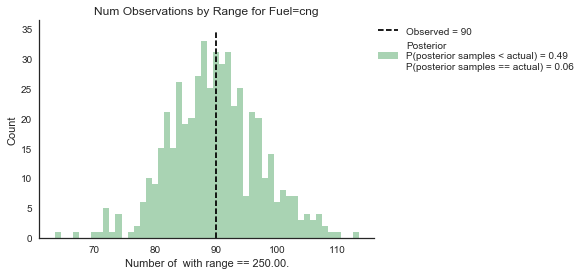

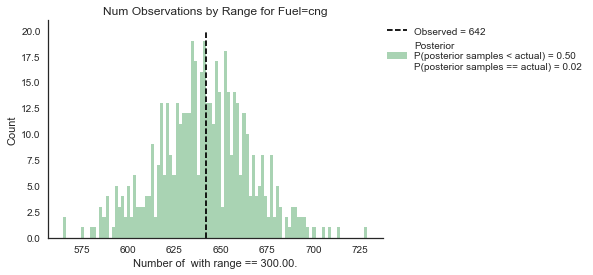

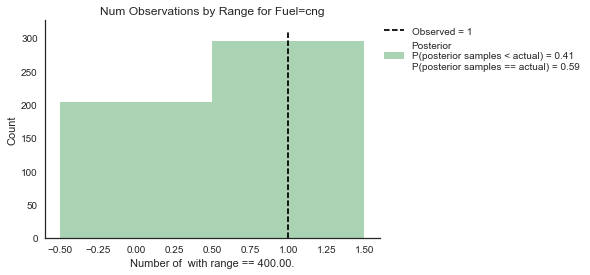

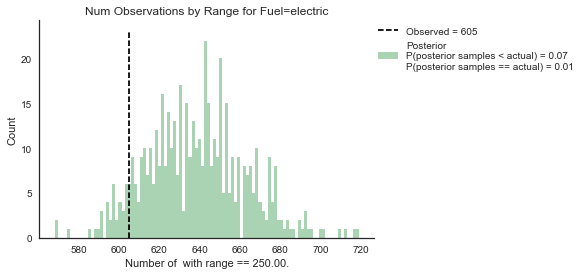

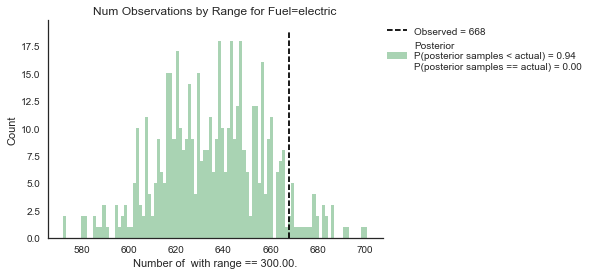

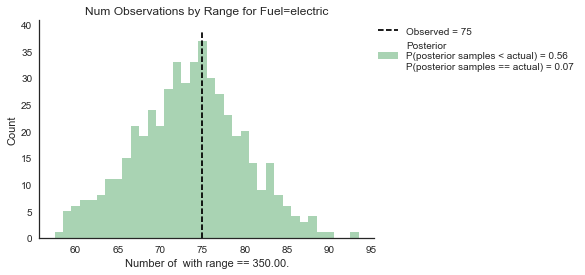

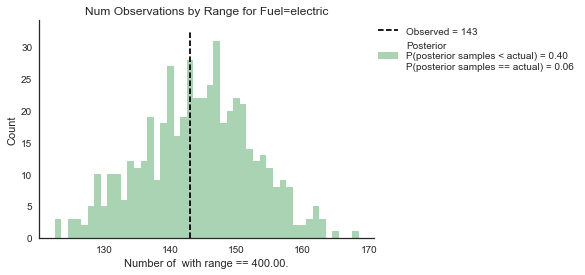

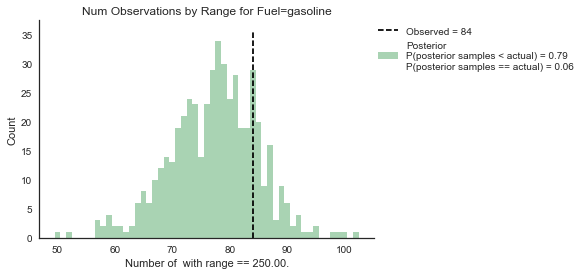

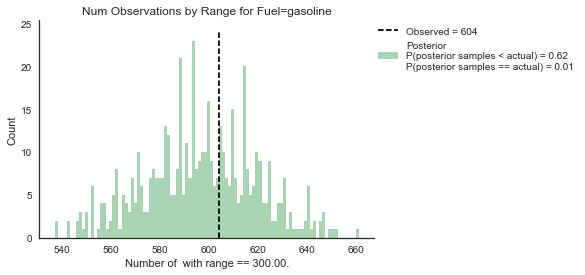

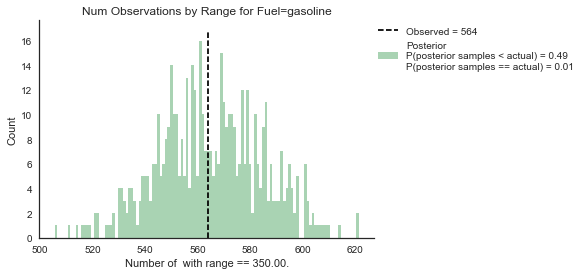

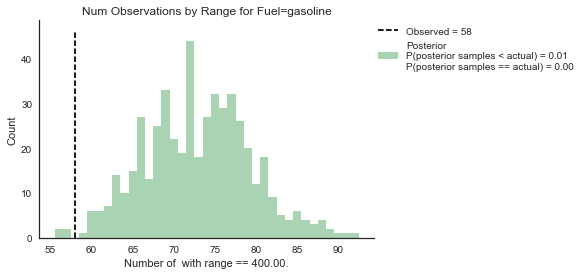

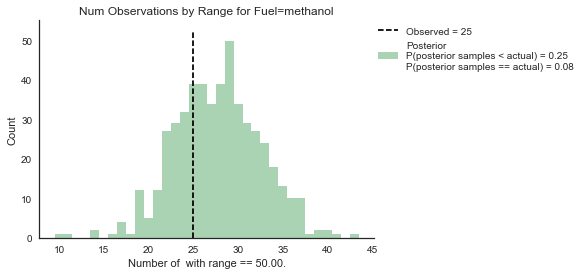

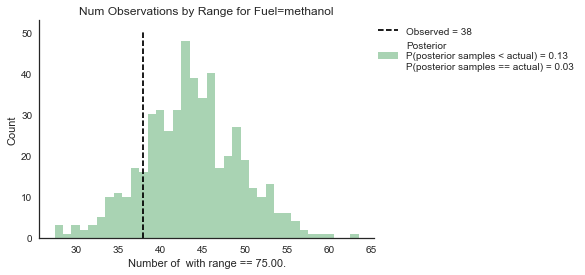

In [16]:
# Check the price variable for all of the various modes.
for fuel in np.sort(car_df.fuel_type.unique()):
    filter_row = car_df.fuel_type == fuel
    current_title = 'Num Observations by Range for Fuel={}'

    viz.plot_categorical_predictive_densities(
        car_df,
        None,
        likelihood_sim_y,
        'range',
        filter_row,
        car_mnl.choices,
        title=current_title.format(fuel))

Based on the plots above, we can see that our model systematically:
1. under predicts compressed natural gas vehicles with range = 150
2. over predicts electric vehicles with range = 250
3. under predicts electric vehicles with range = 300
4. over predicts gasoline vehicles with range = 400

## Acceleration

In [17]:
car_df.loc[car_df.choice == 1, 'acceleration'].value_counts()

2.5    1680
4.0    1634
6.0    1340
Name: acceleration, dtype: int64

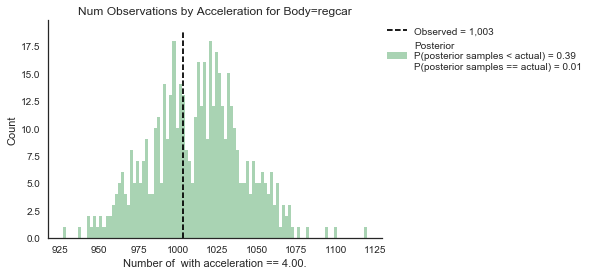

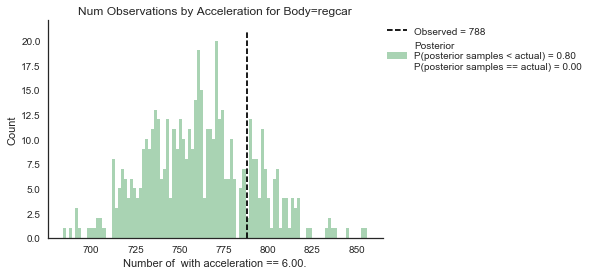

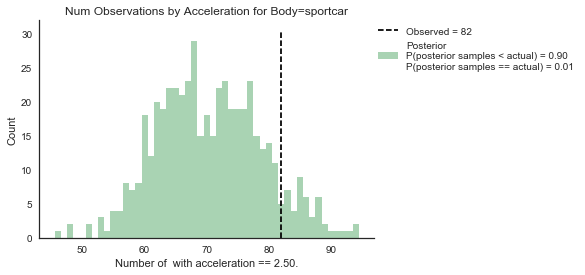

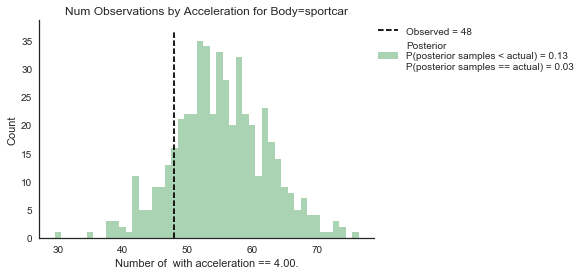

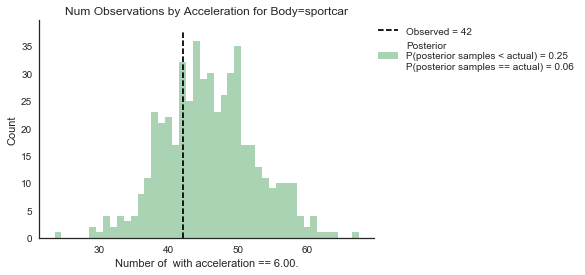

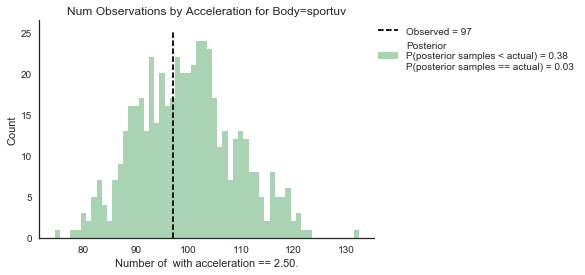

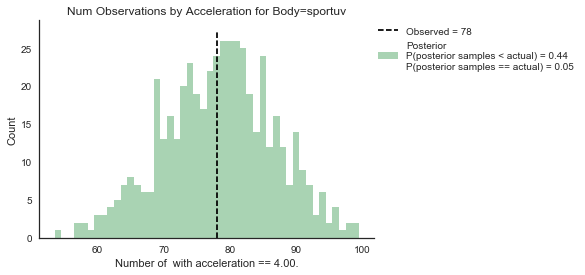

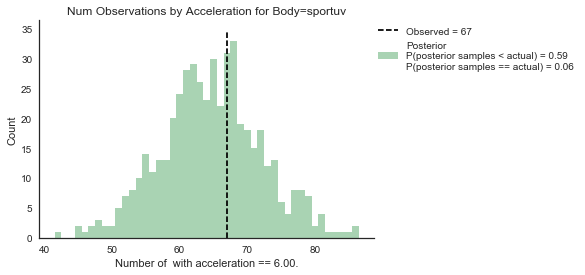

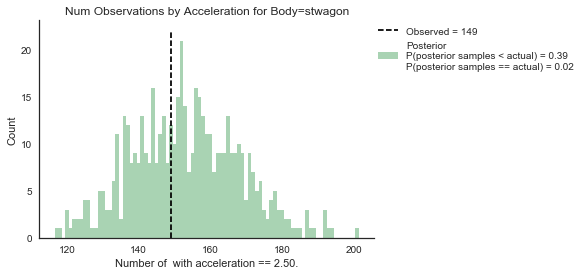

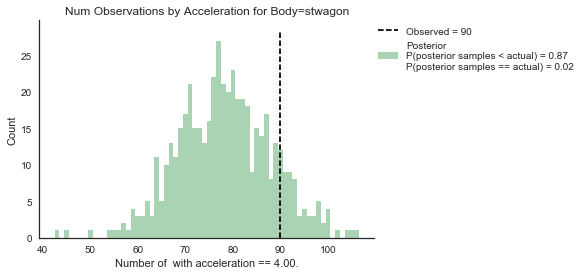

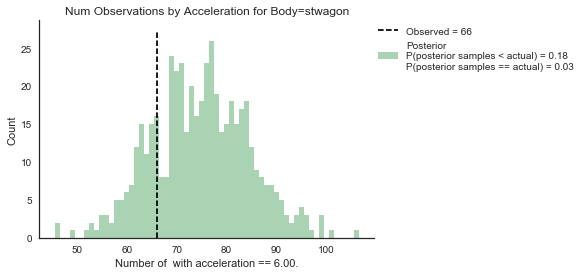

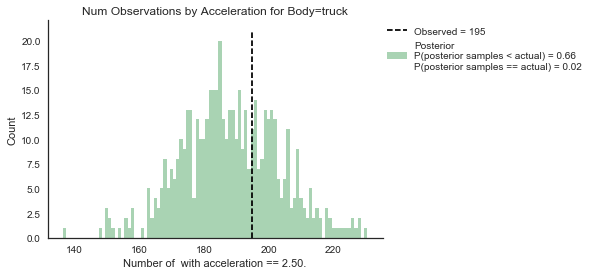

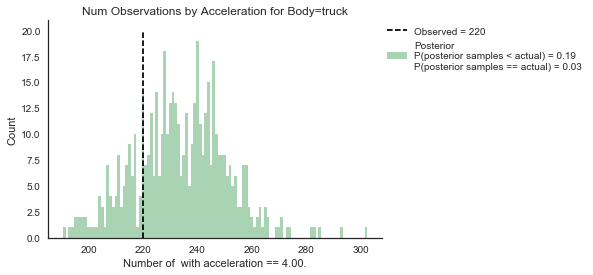

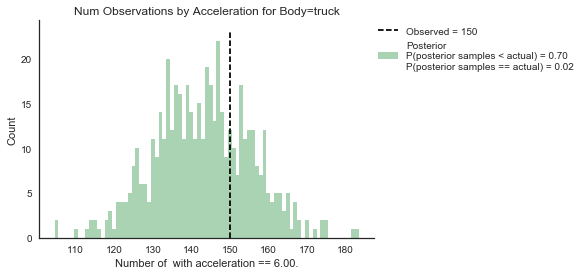

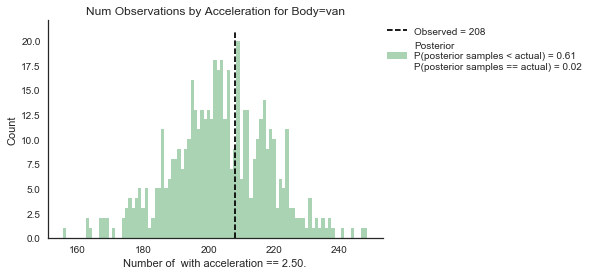

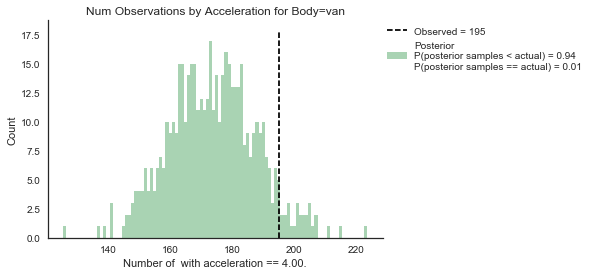

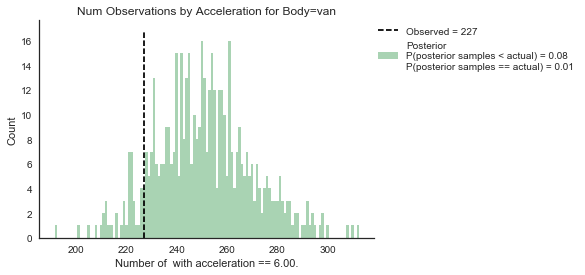

In [18]:
# Check the price variable for all of the various modes.
for body in np.sort(car_df.body_type.unique()):
    filter_row = car_df.body_type == body
    
    current_title = 'Num Observations by Acceleration for Body={}'
    
    viz.plot_categorical_predictive_densities(
        car_df,
        None,
        likelihood_sim_y,
        'acceleration',
        filter_row,
        car_mnl.choices,
        title=current_title.format(body))
    

From above, we see that we:
1. underpredict the number of sports cars with Acceleration = 2.5
2. unerpredict the number of vans with Acceleration = 4.0
3. underpredict the number of station wagons with Acceleration = 4.0
3. overpredict the number of sports cars with Acceleration = 6.0

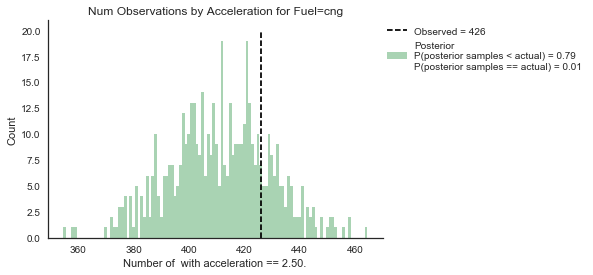

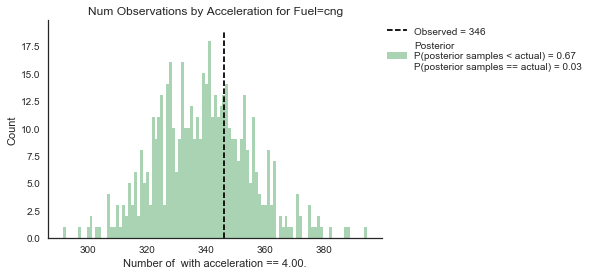

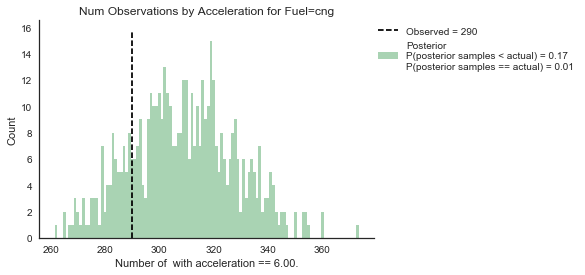

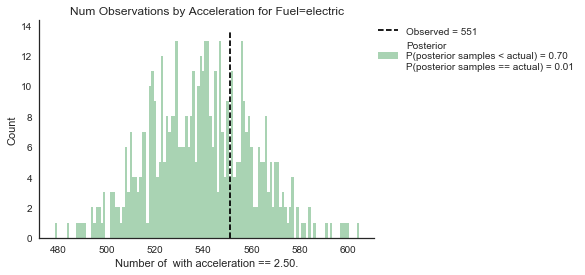

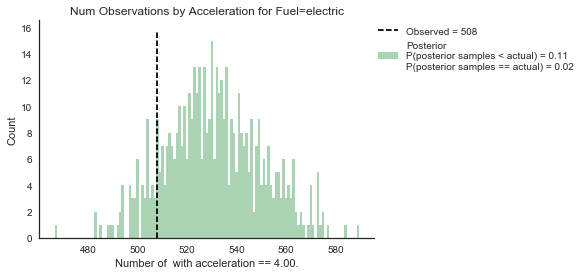

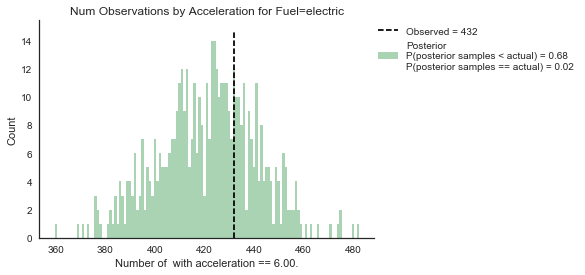

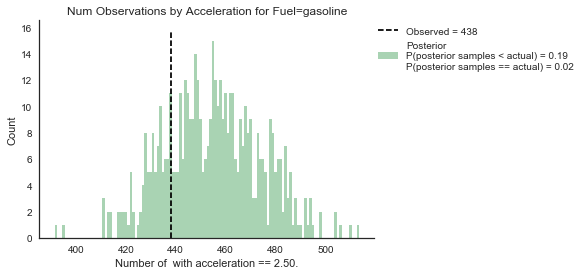

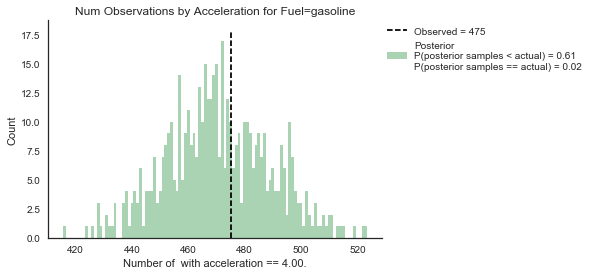

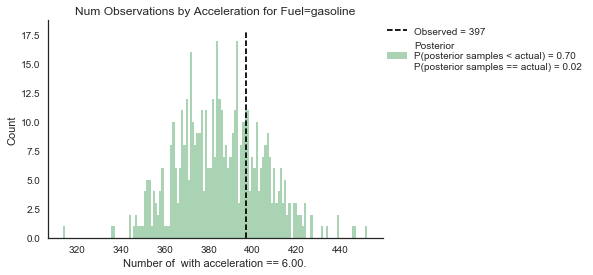

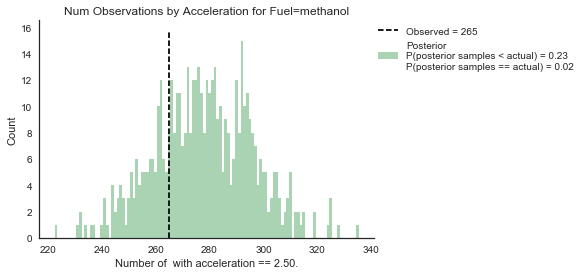

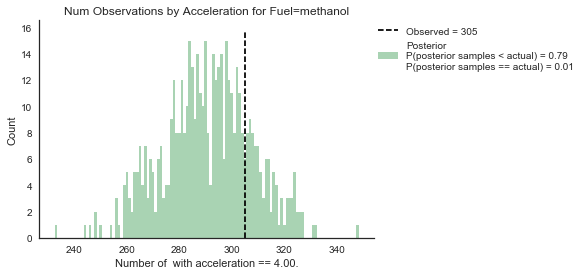

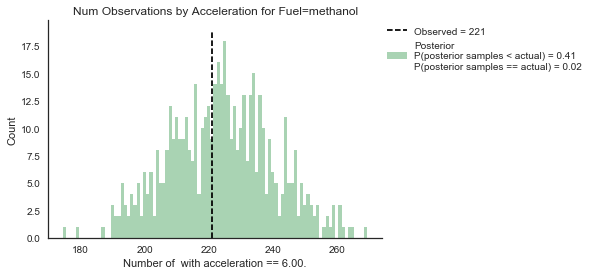

In [19]:
# Check the price variable for all of the various modes.
for fuel in np.sort(car_df.fuel_type.unique()):
    filter_row = car_df.fuel_type == fuel
    current_title = 'Num Observations by Acceleration for Fuel={}'

    viz.plot_categorical_predictive_densities(
        car_df,
        None,
        likelihood_sim_y,
        'acceleration',
        filter_row,
        car_mnl.choices,
        title=current_title.format(fuel))

With respect to acceleration by vehicle fuel type, our model appears to adequately capture the observed relationships.

## Top speed

In [20]:
car_df.loc[car_df.choice == 1, 'top_speed'].value_counts()

85     1183
140    1016
110     963
95      938
100     205
65      180
55      169
Name: top_speed, dtype: int64

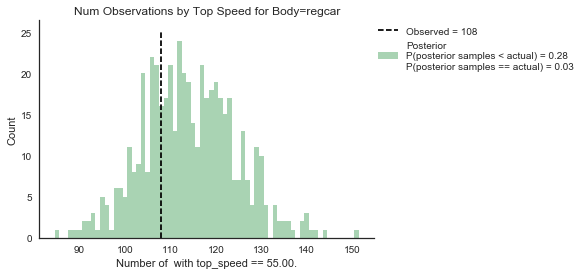

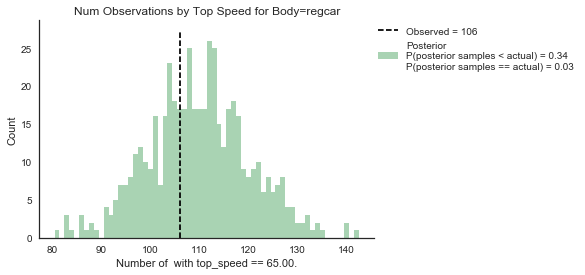

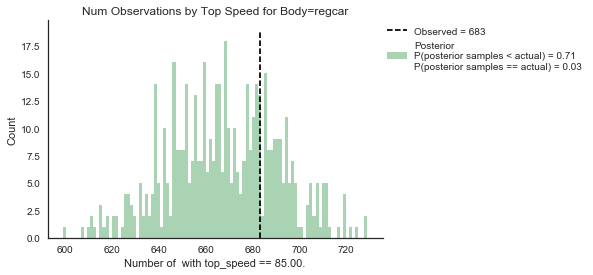

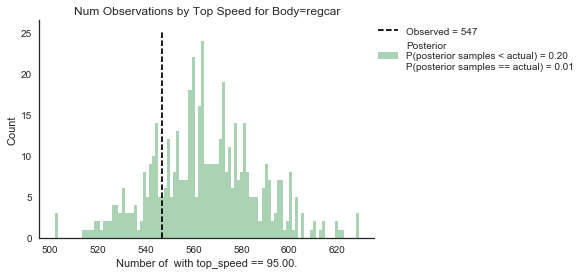

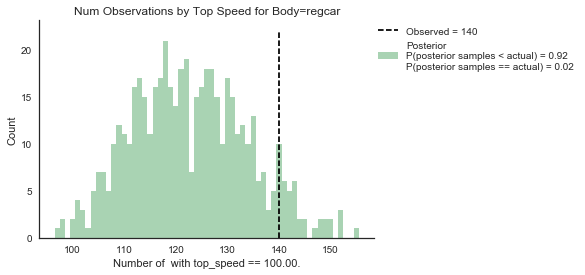

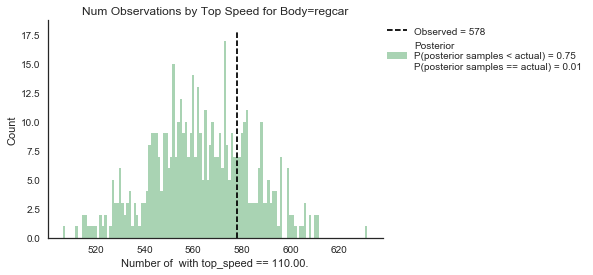

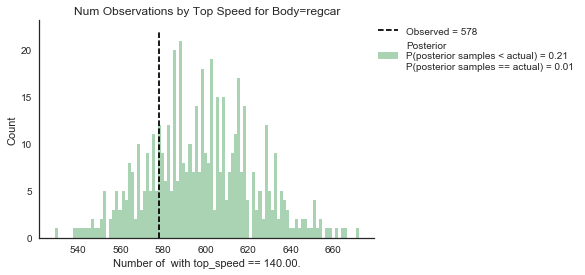

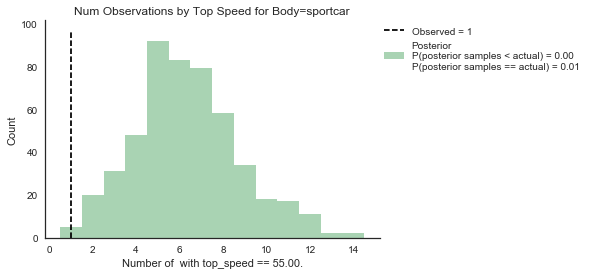

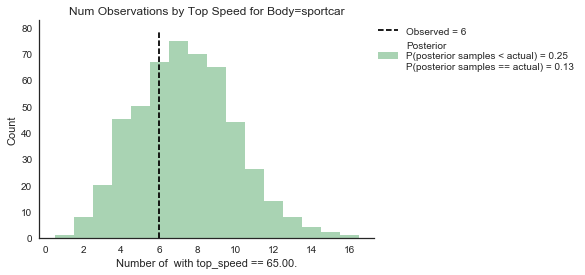

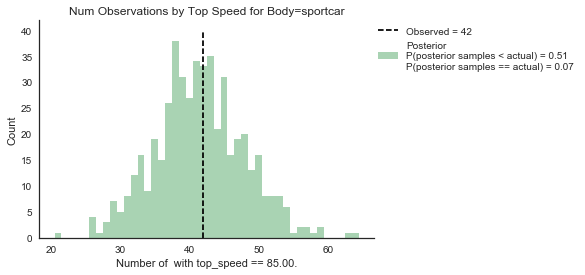

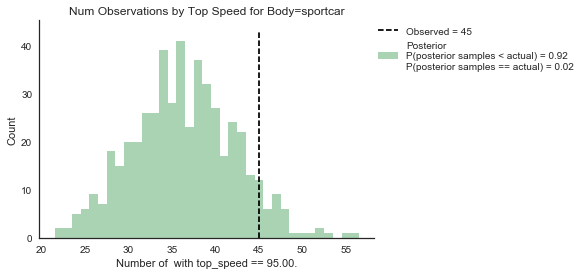

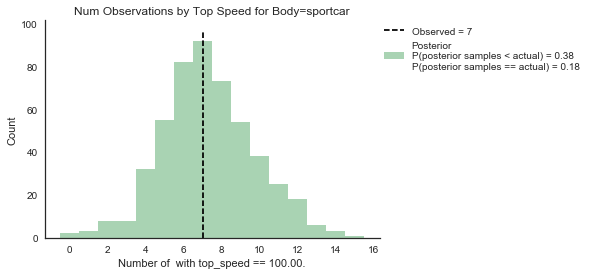

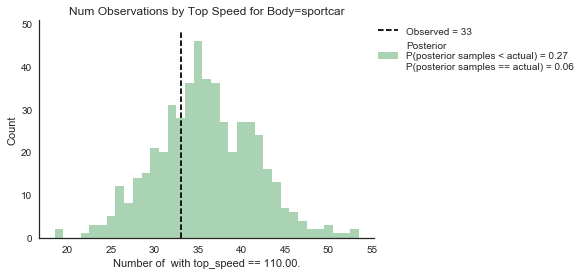

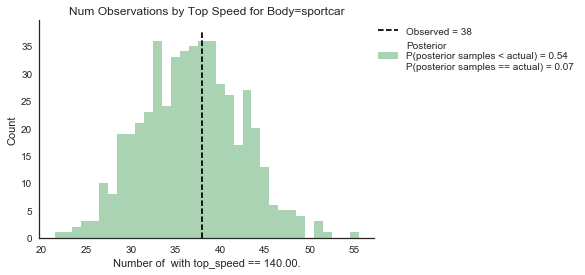

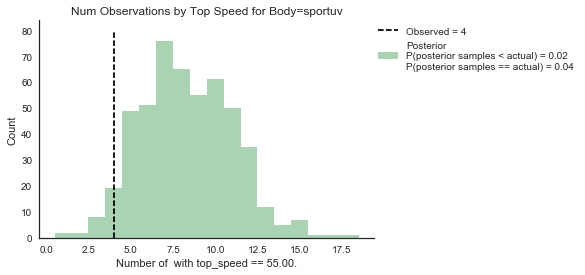

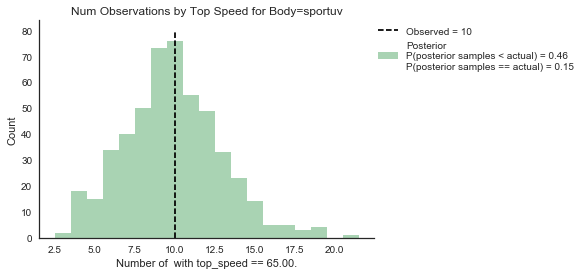

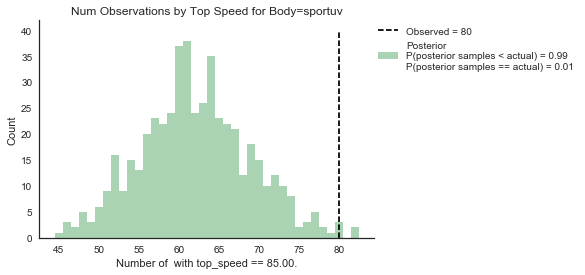

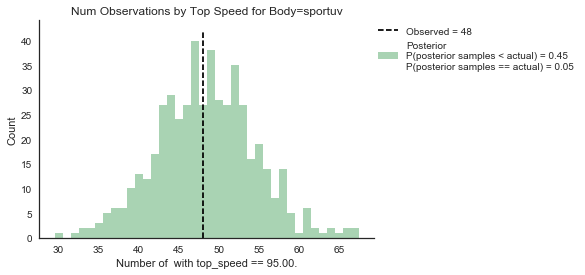

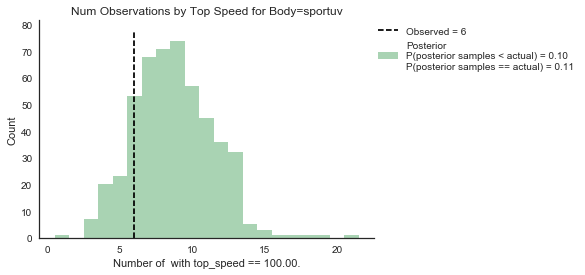

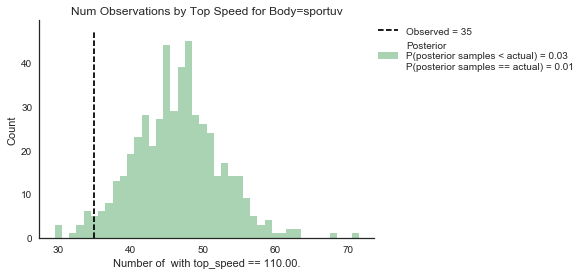

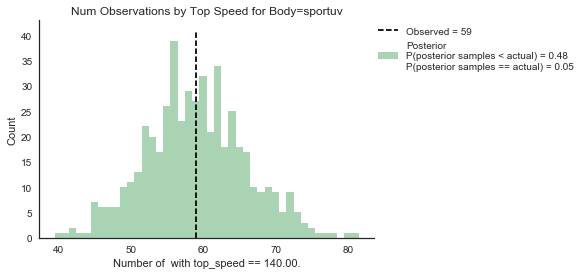

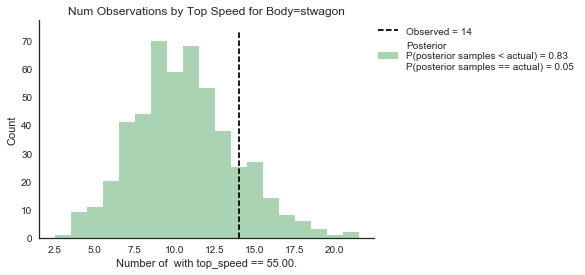

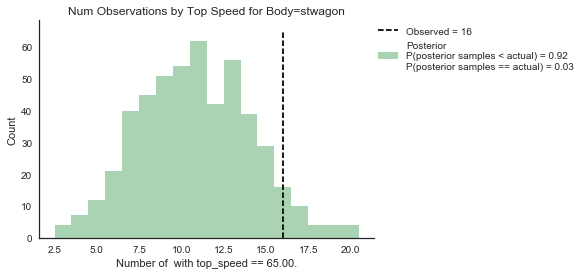

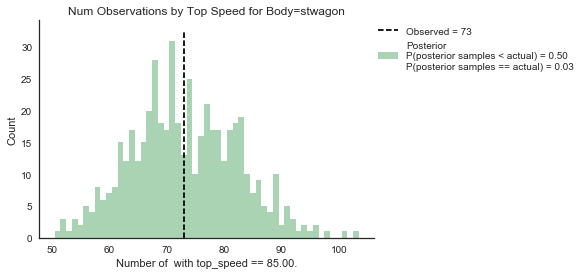

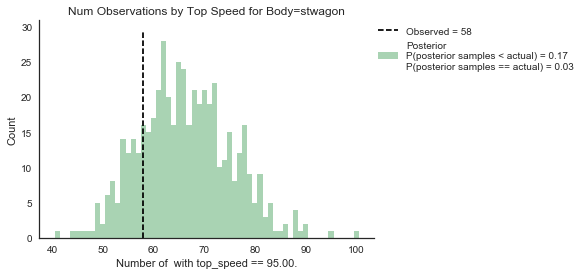

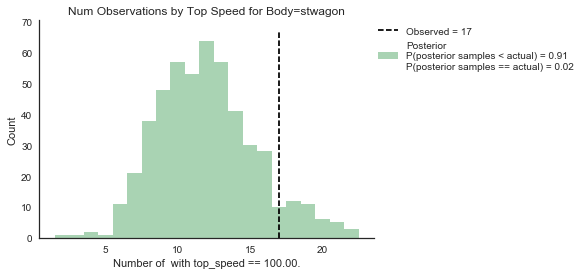

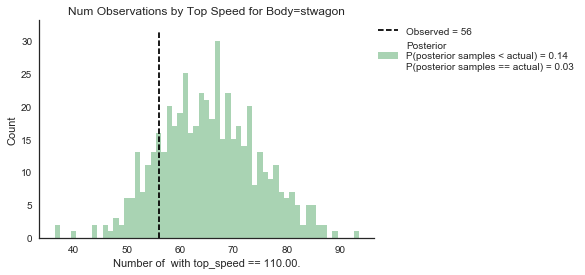

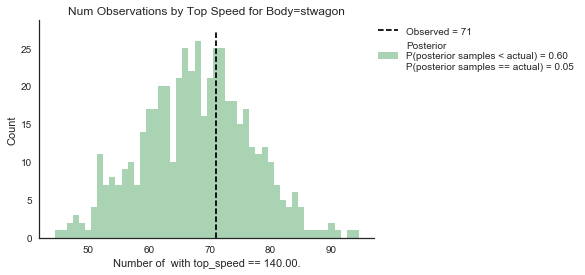

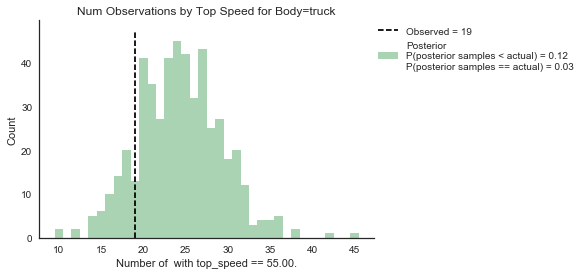

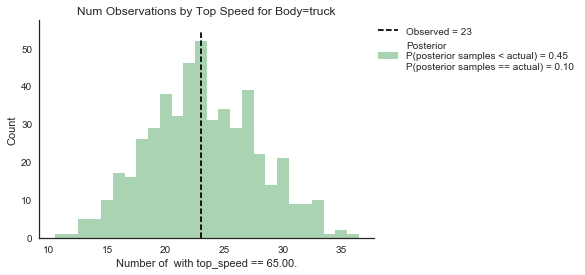

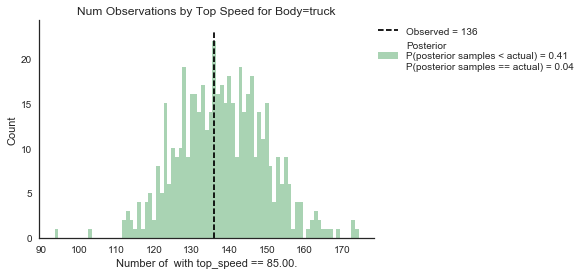

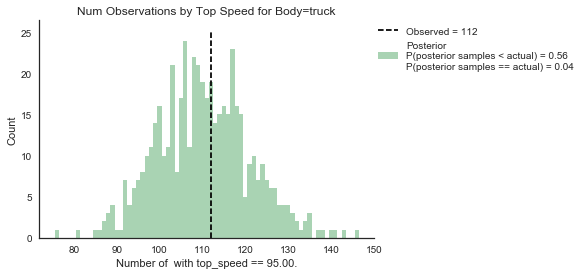

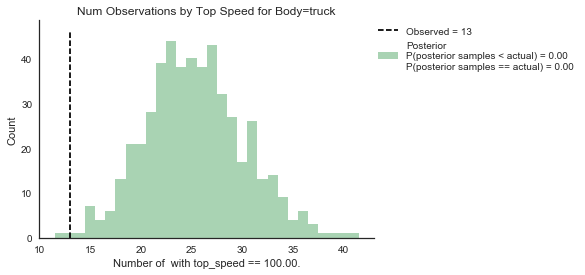

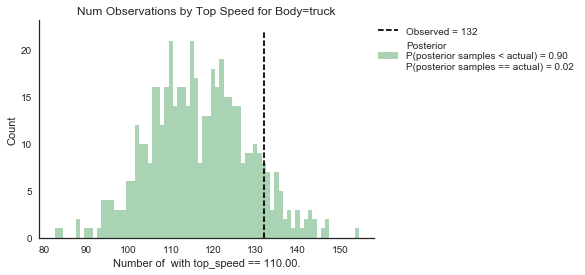

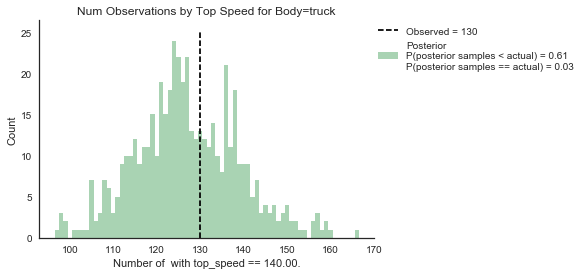

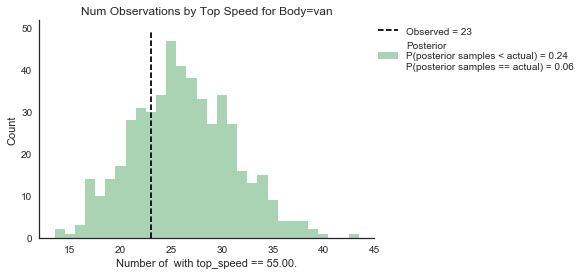

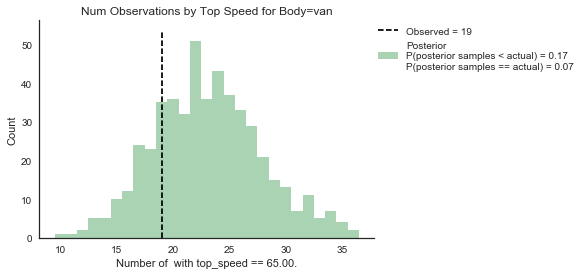

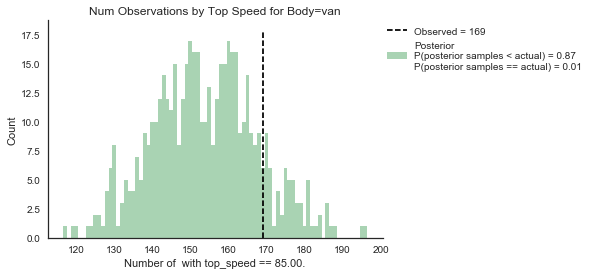

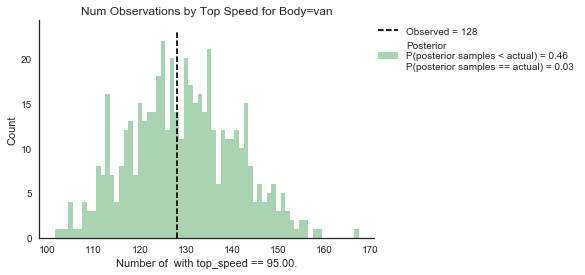

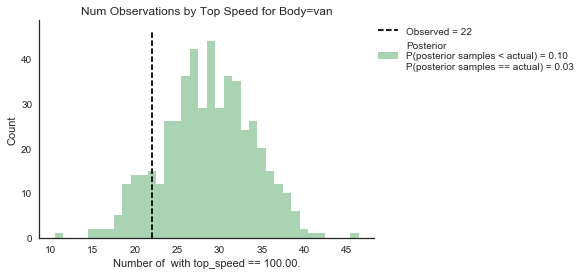

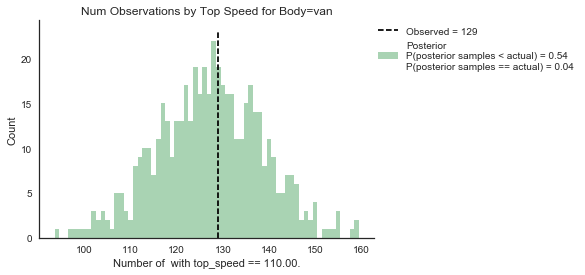

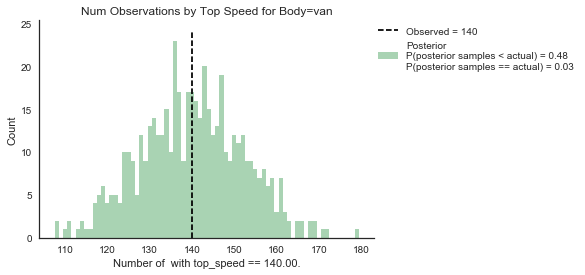

In [21]:
# Check the price variable for all of the various modes.
for body in np.sort(car_df.body_type.unique()):
    filter_row = car_df.body_type == body
    
    current_title = 'Num Observations by Top Speed for Body={}'
    
    viz.plot_categorical_predictive_densities(
        car_df,
        None,
        likelihood_sim_y,
        'top_speed',
        filter_row,
        car_mnl.choices,
        title=current_title.format(body))
    

What we can see is that we:
1. under predict regular car with top speed = 100
2. over predict sports cars with top speeds = 55
3. under predict sports car with top speed = 95
4. over predict sports utility vehicles with top speeds = 55
5. under predict sports utility vehicles with top speed = 85
6. over predict sports utility vehicles with top speeds = 110
7. under predict station wagons with top speed = 65
8. under predict station wagons with top speed = 100
9. over predict trucks with top speeds = 100
10. underpredict trucks with top speeds = 110
11. over predict vans with top speeds = 100

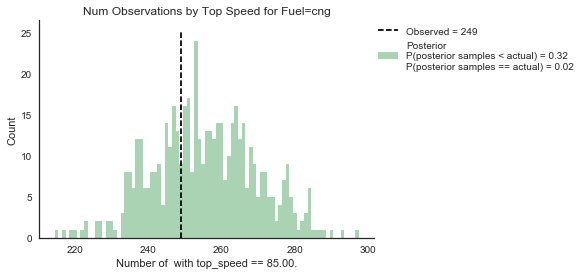

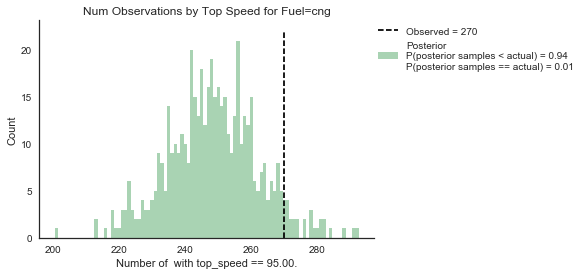

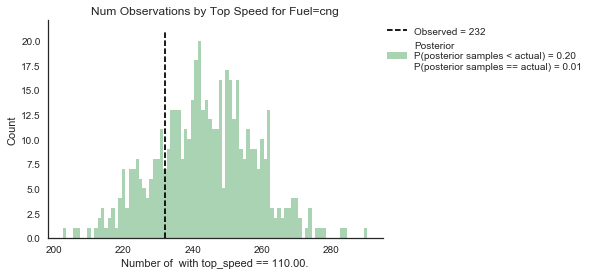

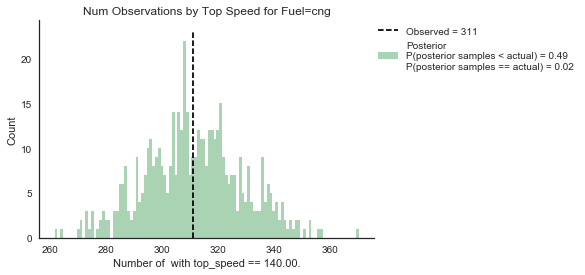

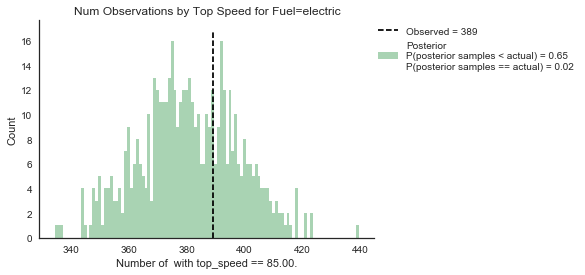

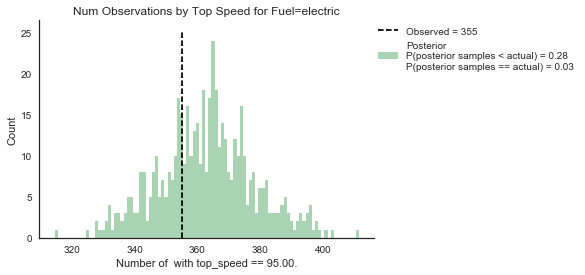

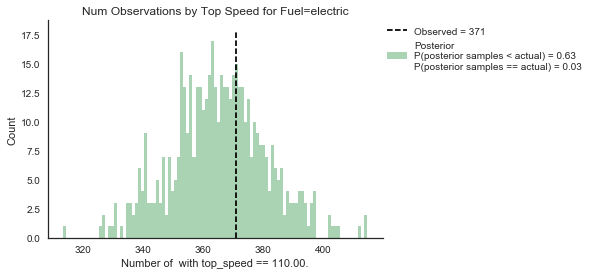

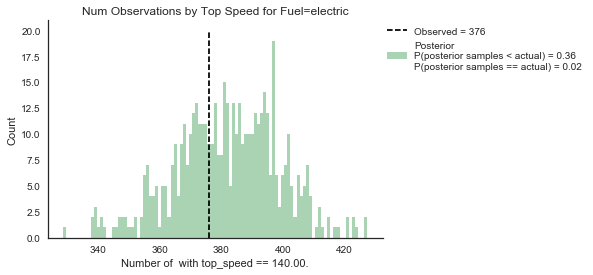

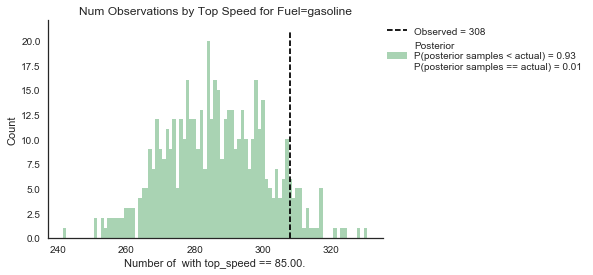

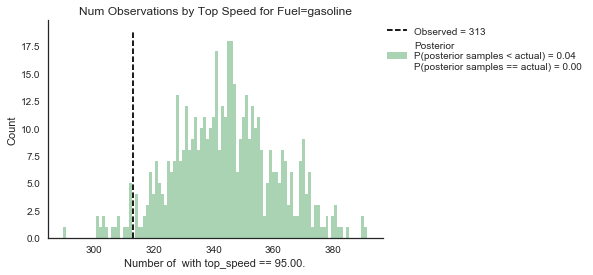

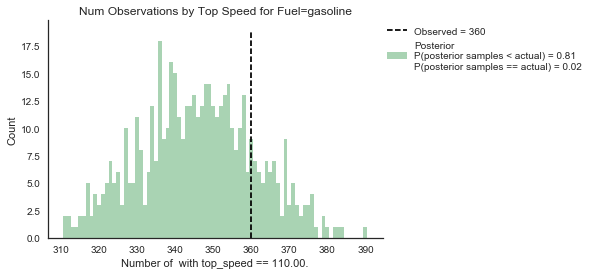

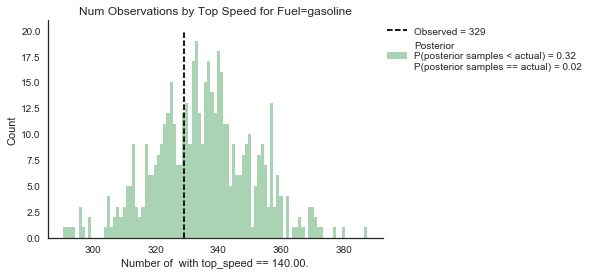

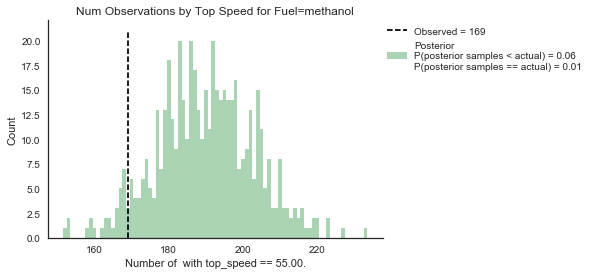

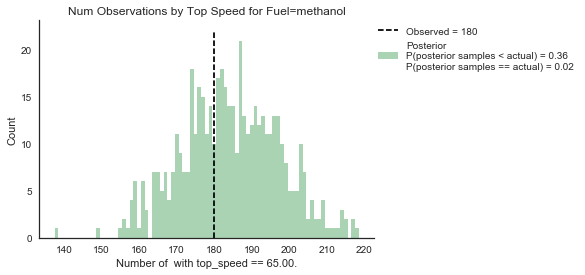

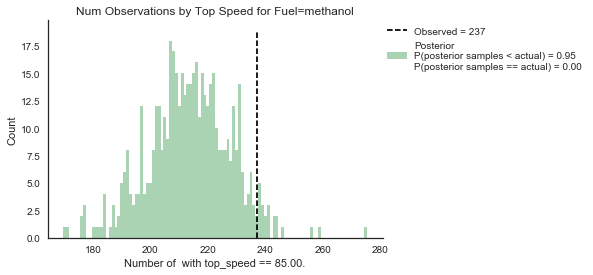

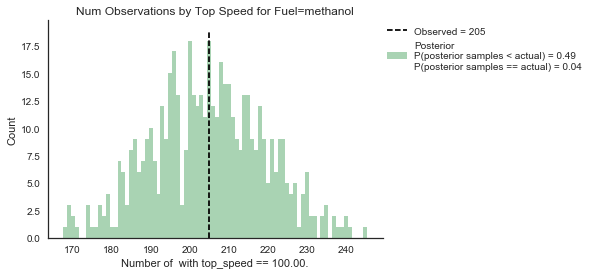

In [22]:
# Check the price variable for all of the various modes.
for fuel in np.sort(car_df.fuel_type.unique()):
    filter_row = car_df.fuel_type == fuel
    current_title = 'Num Observations by Top Speed for Fuel={}'

    viz.plot_categorical_predictive_densities(
        car_df,
        None,
        likelihood_sim_y,
        'top_speed',
        filter_row,
        car_mnl.choices,
        title=current_title.format(fuel))

From the plots above, we see that our model systematically:
1. under predicts CNG vehicles with top speed = 95
2. under predicts gasoline vehicles with top speed = 85
3. over predicts gasoline vehicles with top speed = 95
4. over predicts methanol vehicles with top speed = 55
5. under predicts methanol vehicles with top speed = 85

## Pollution

In [23]:
car_df.loc[car_df.choice == 1, 'pollution'].value_counts()

0.25    982
0.00    791
0.40    666
0.75    641
0.60    634
0.50    339
1.00    318
0.10    283
Name: pollution, dtype: int64

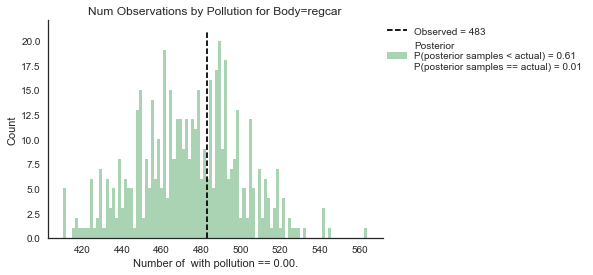

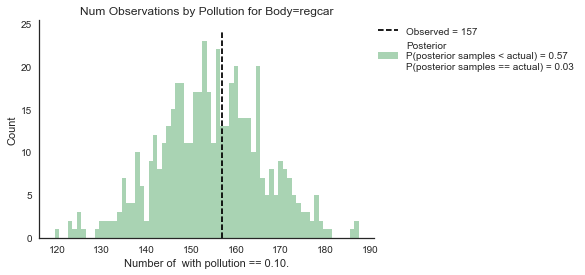

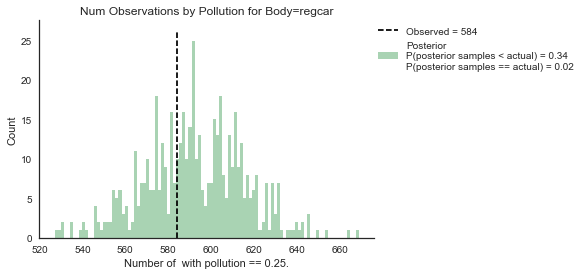

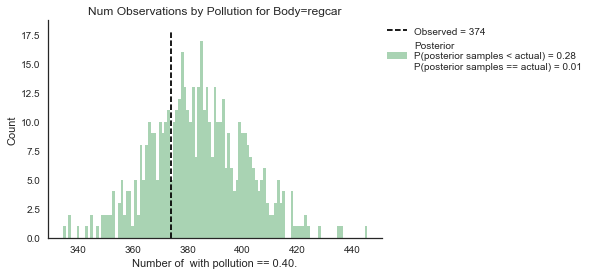

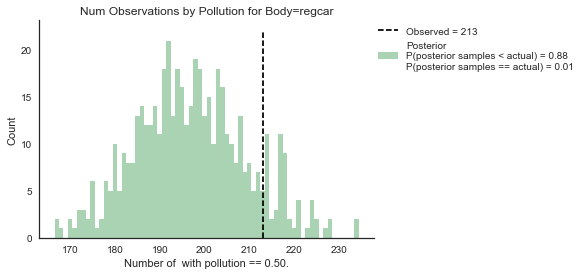

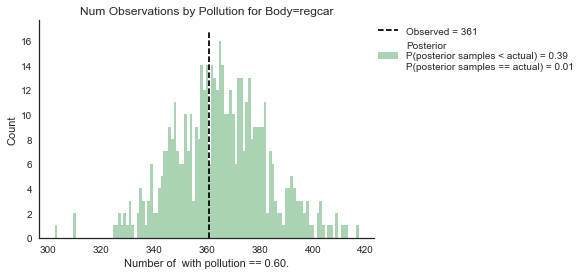

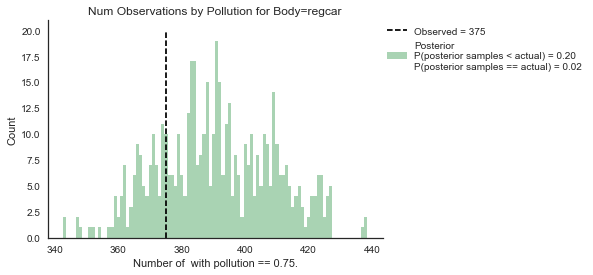

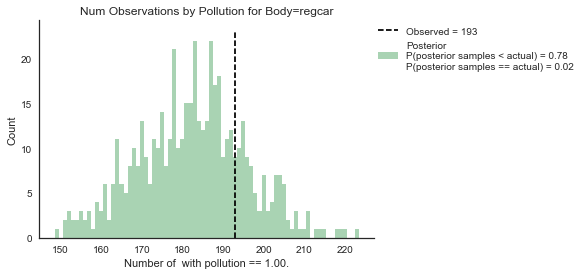

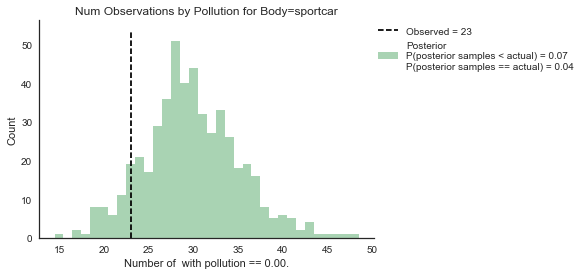

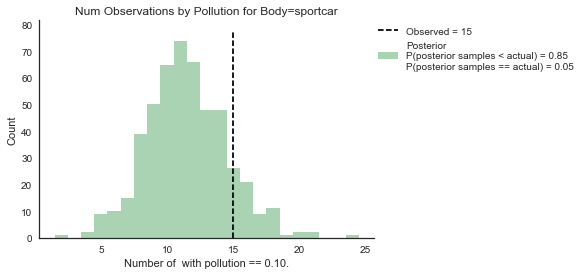

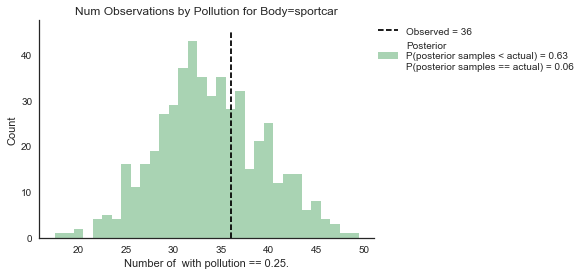

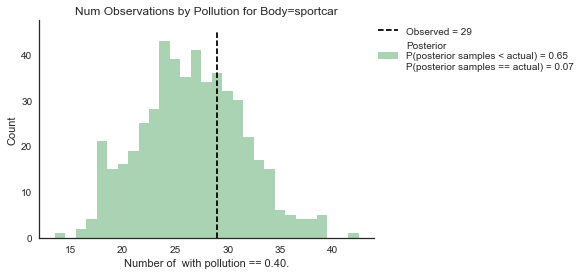

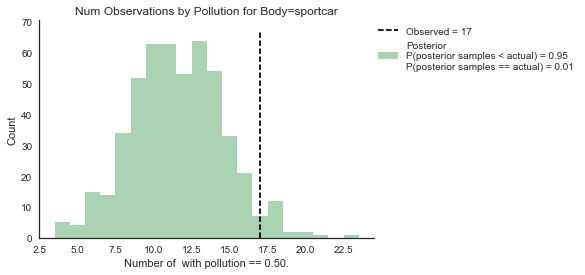

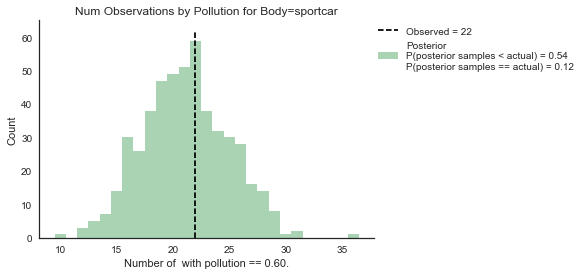

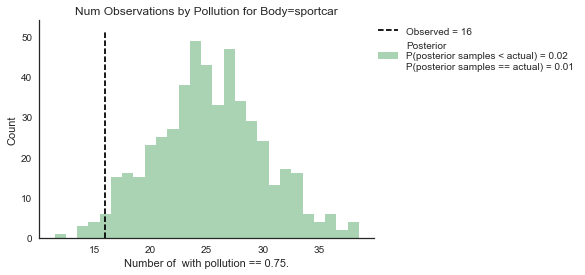

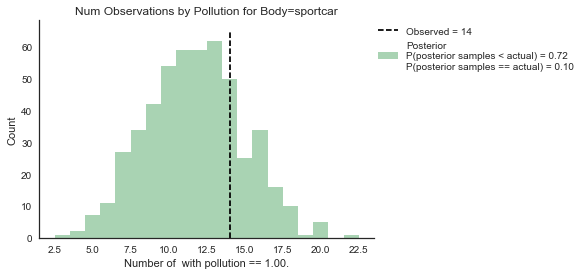

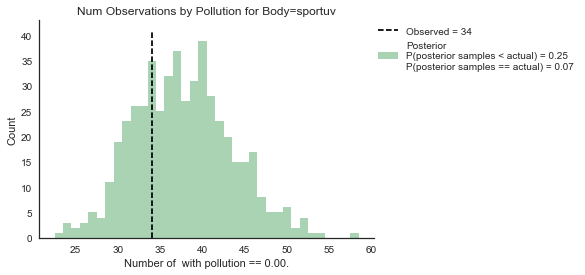

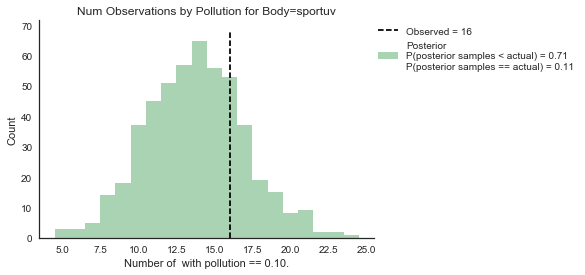

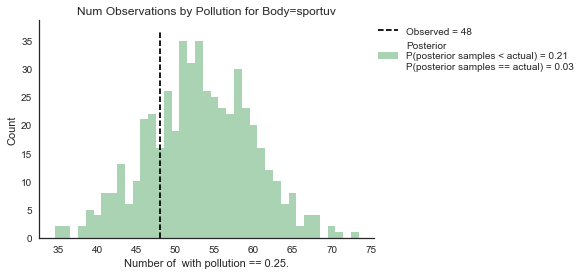

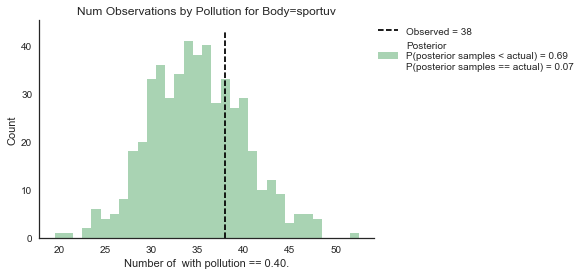

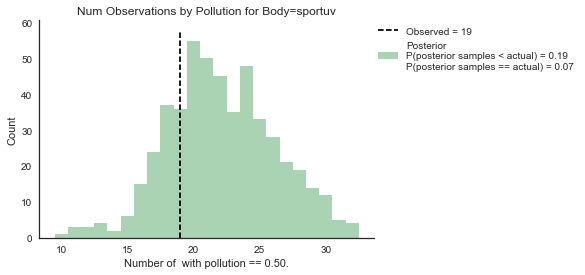

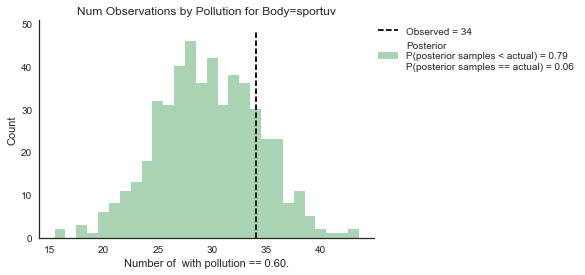

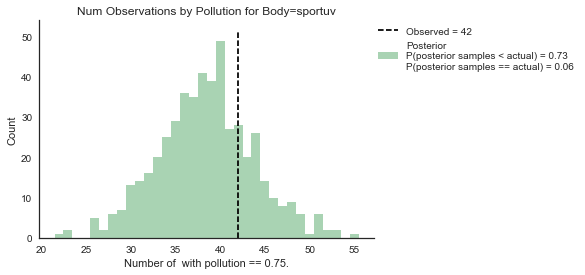

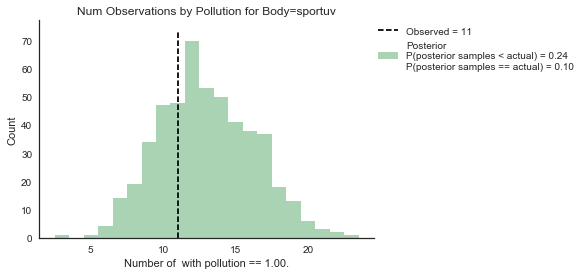

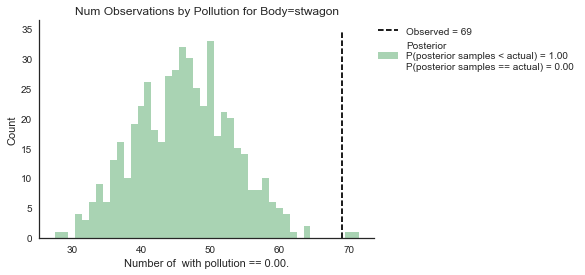

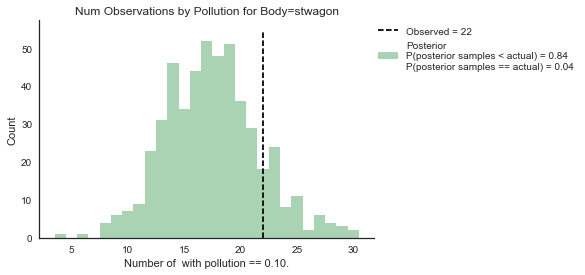

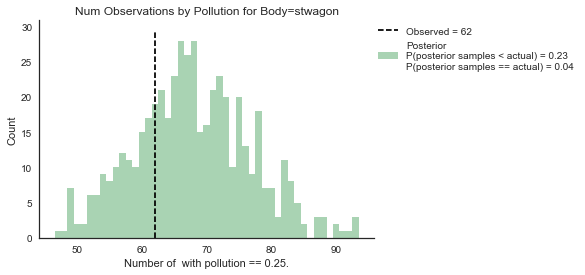

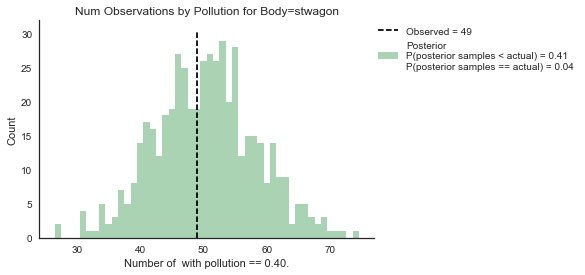

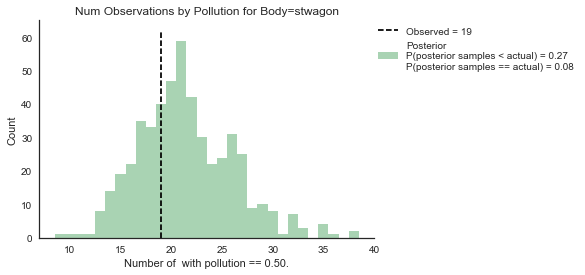

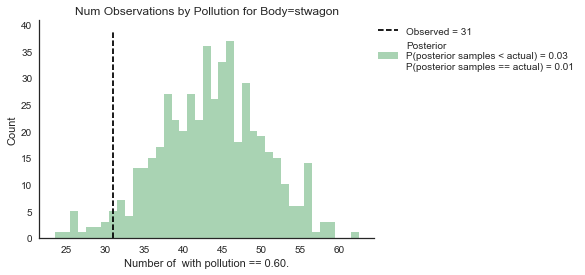

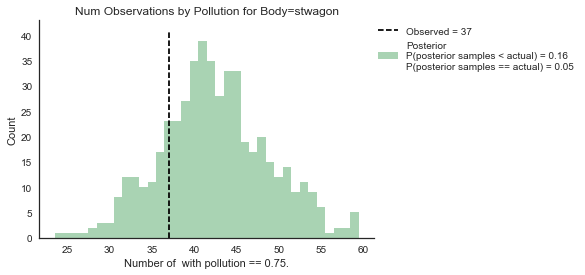

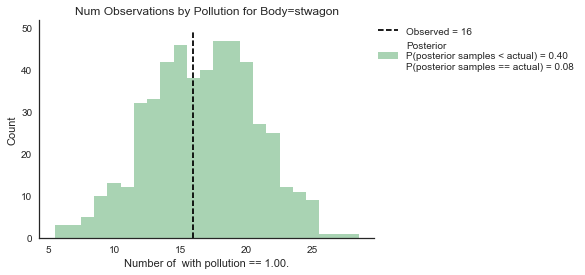

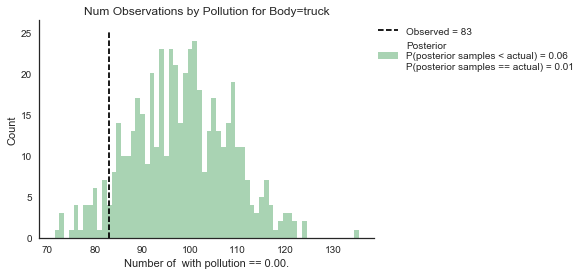

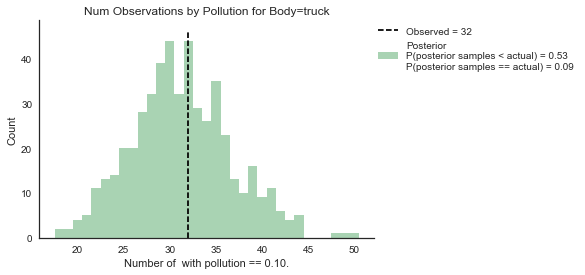

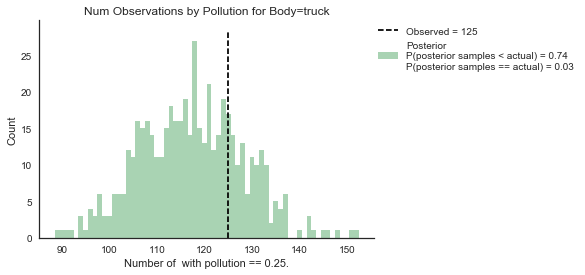

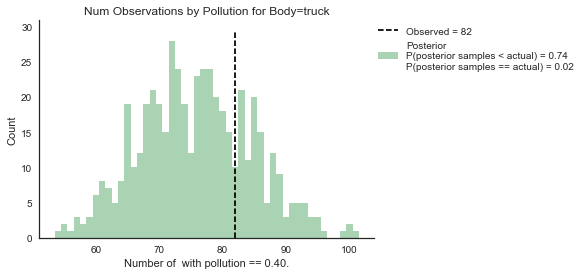

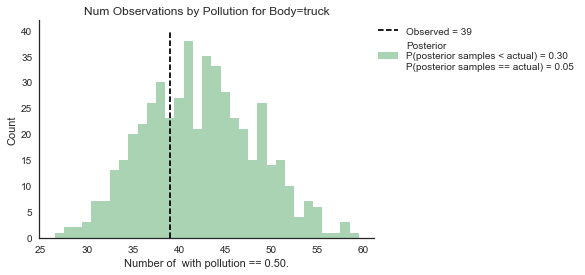

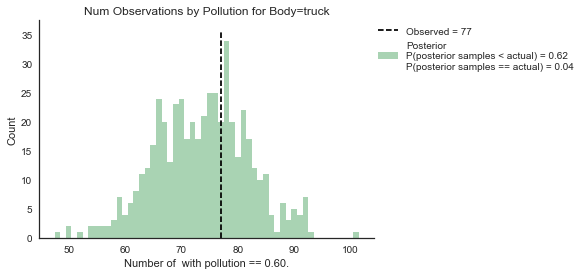

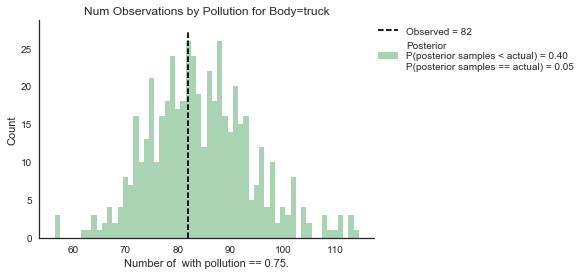

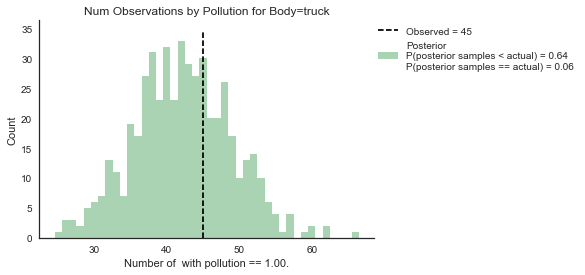

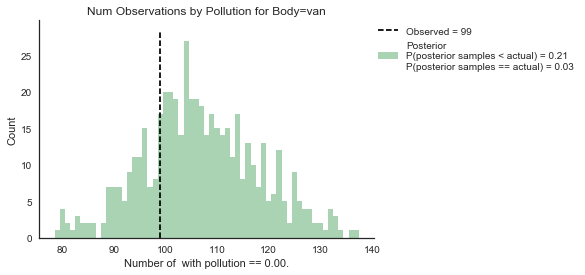

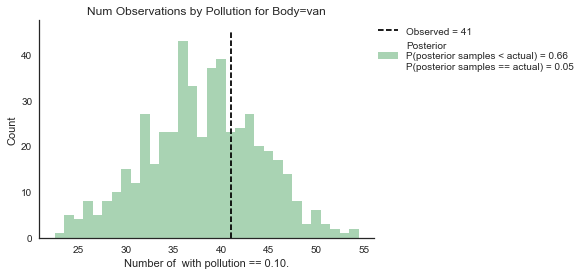

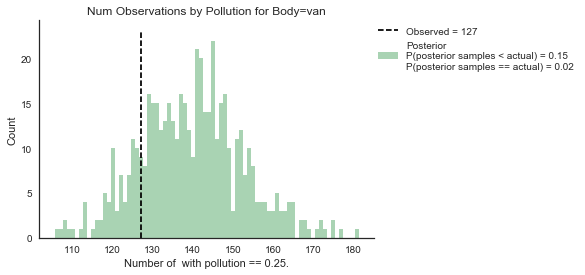

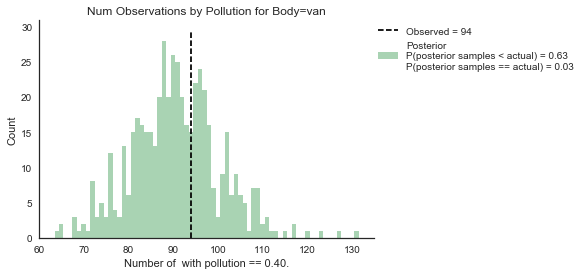

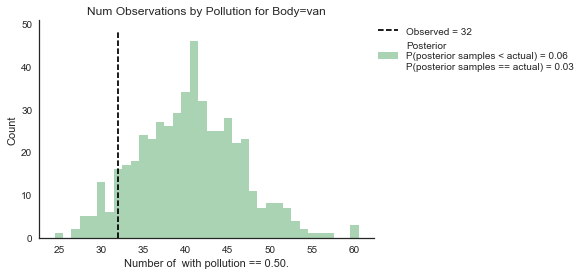

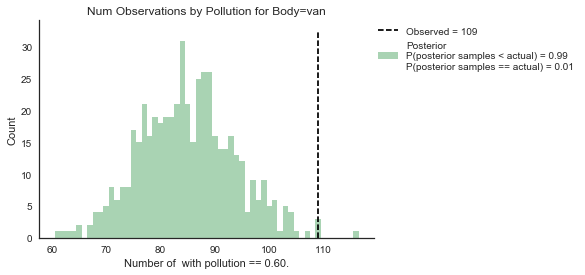

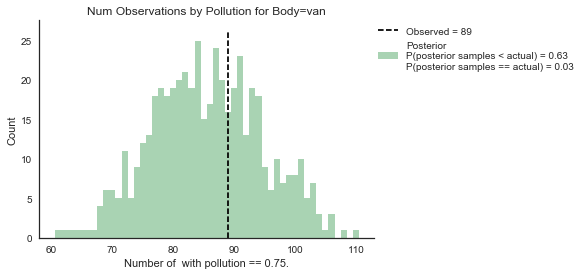

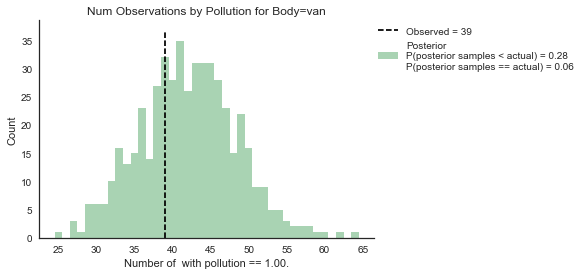

In [24]:
# Check the price variable for all of the various modes.
for body in np.sort(car_df.body_type.unique()):
    filter_row = car_df.body_type == body
    
    current_title = 'Num Observations by Pollution for Body={}'
    
    viz.plot_categorical_predictive_densities(
        car_df,
        None,
        likelihood_sim_y,
        'pollution',
        filter_row,
        car_mnl.choices,
        title=current_title.format(body))
    

What we see is that we:
1. over predict sports cars with pollution = 0
2. under predict sports cars with pollution = 0.1
3. under predict sports cars with pollution = 0.5
4. overpredict sports cars with pollution = 0.75
5. under predict station wagons with pollution = 0
6. under predict station wagons with pollution = 0.1
7. over predict station wagons with pollution = 0.6
8. over predict trucks with pollution = 0
9. over predict vans with pollution = 0.5
10. under predict vans with pollution = 0.6

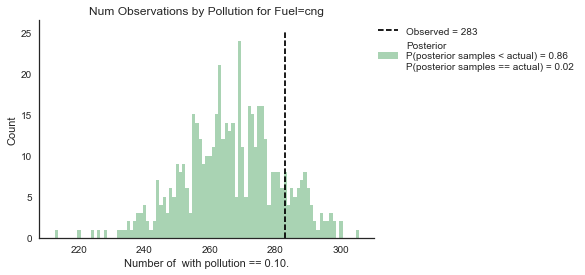

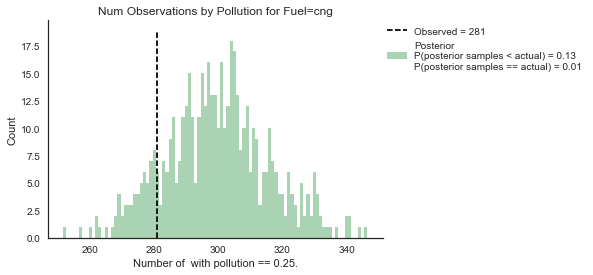

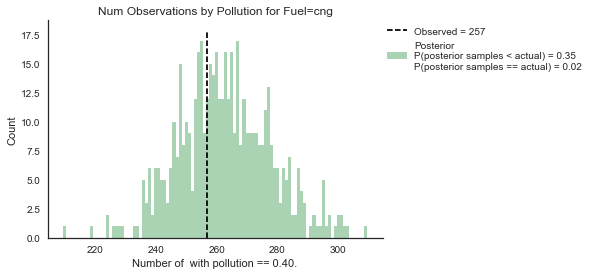

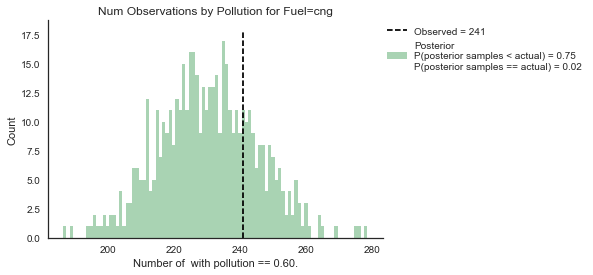

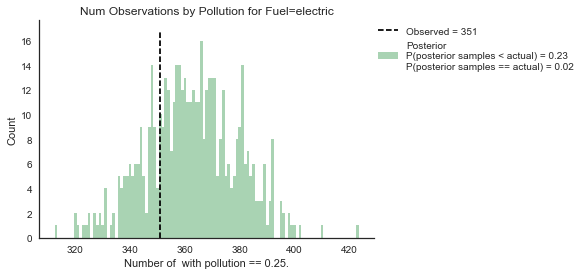

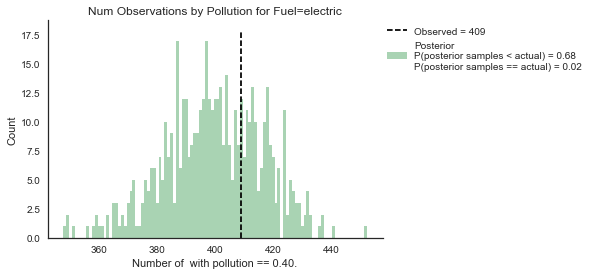

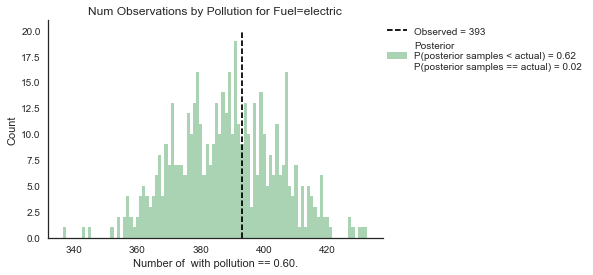

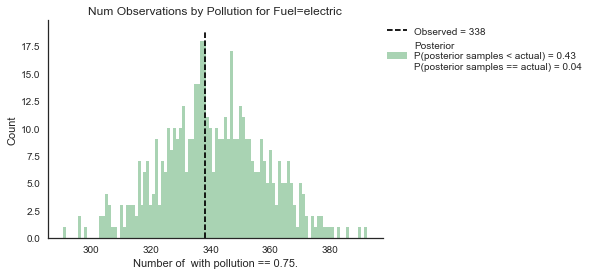

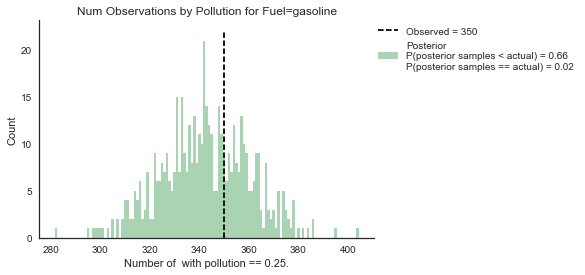

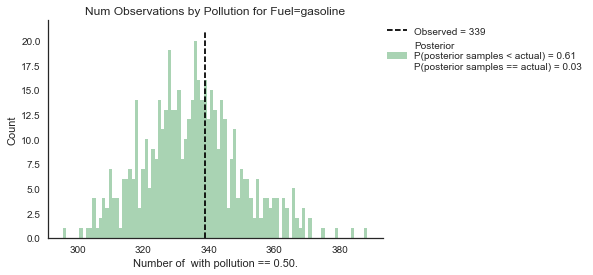

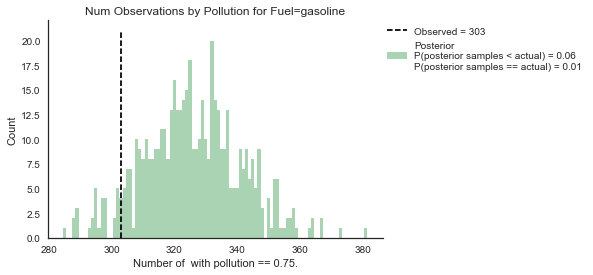

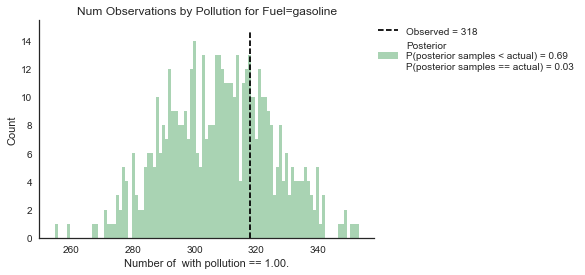

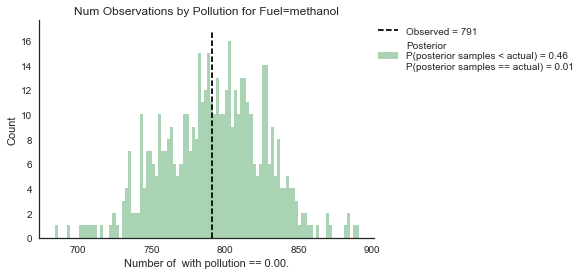

In [25]:
# Check the price variable for all of the various modes.
for fuel in np.sort(car_df.fuel_type.unique()):
    filter_row = car_df.fuel_type == fuel
    current_title = 'Num Observations by Pollution for Fuel={}'

    viz.plot_categorical_predictive_densities(
        car_df,
        None,
        likelihood_sim_y,
        'pollution',
        filter_row,
        car_mnl.choices,
        title=current_title.format(fuel))

From the plots above, we see that our model systematically:
1. over predicts compressed natural gas vehicles with pollution = 0.25
2. over predicts gasoline vehicles with pollution = 0.75

## Vehicle Size

In [26]:
car_df.loc[car_df.choice == 1, 'vehicle_size'].value_counts()

3    2498
2    1507
1     531
0     118
Name: vehicle_size, dtype: int64

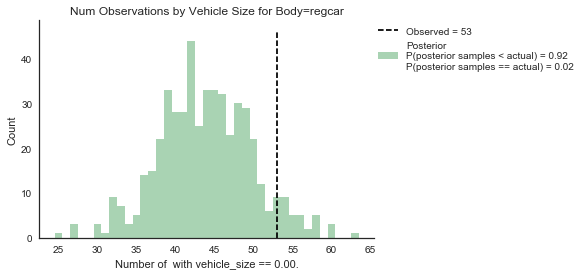

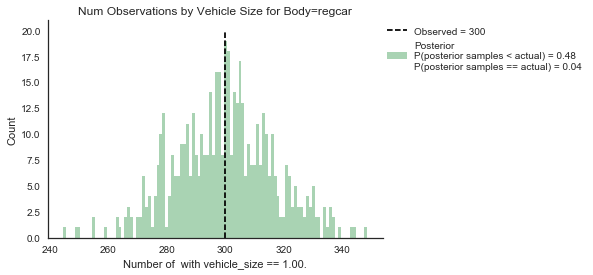

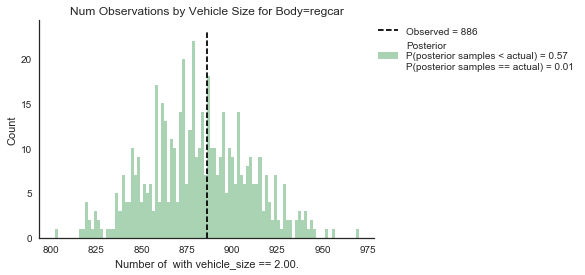

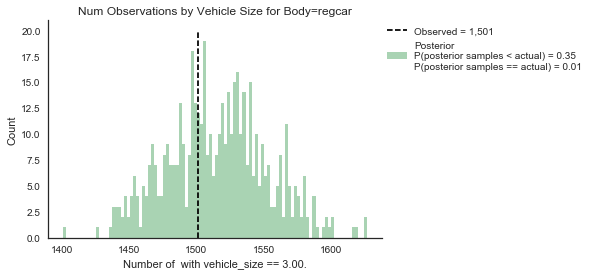

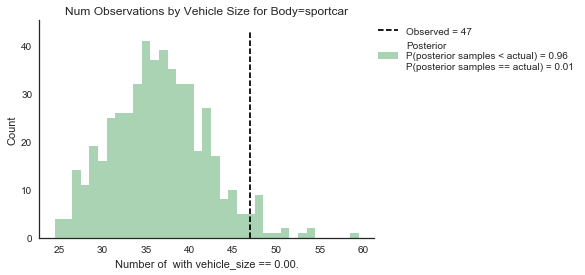

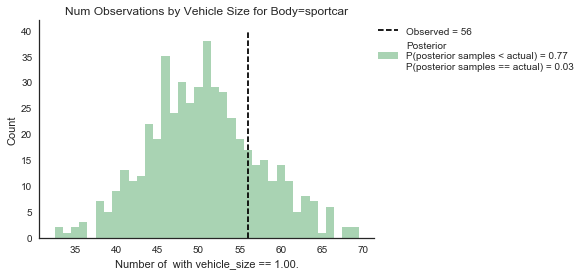

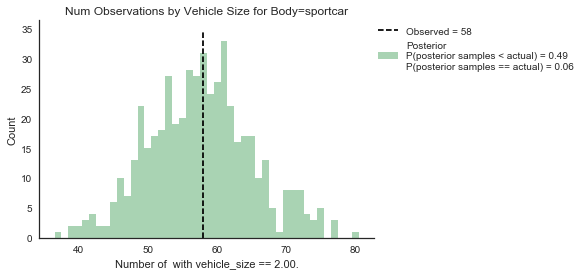

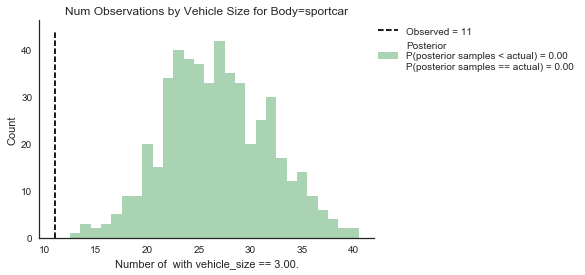

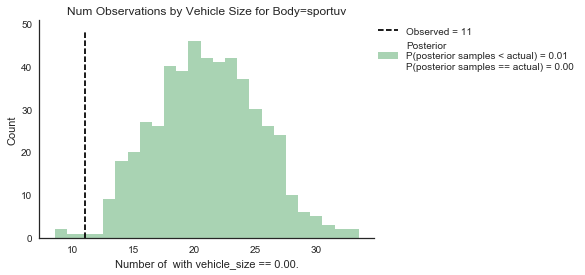

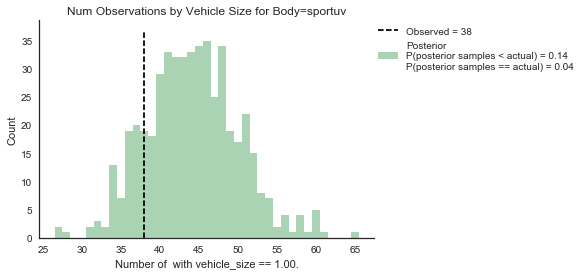

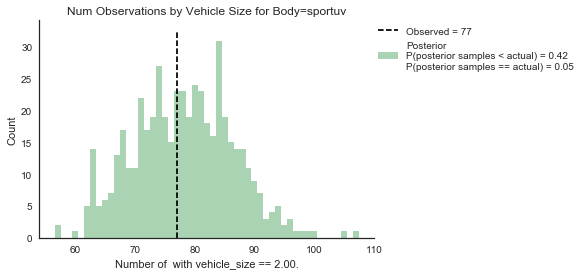

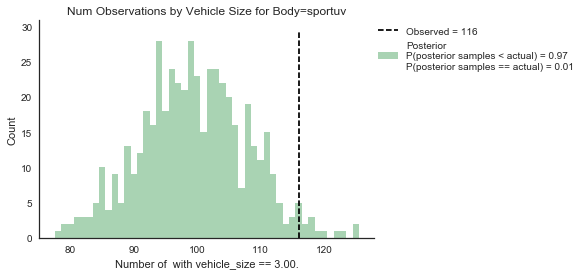

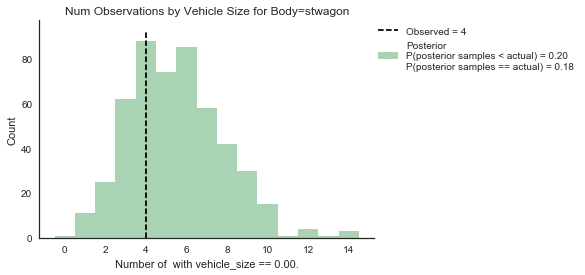

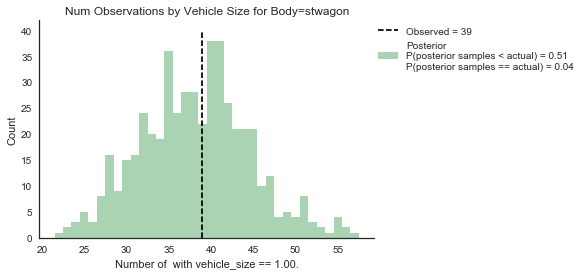

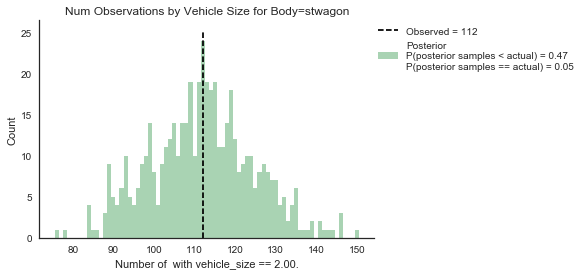

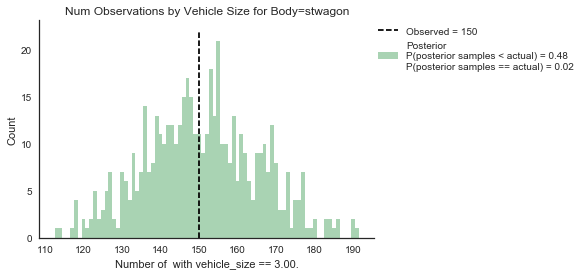

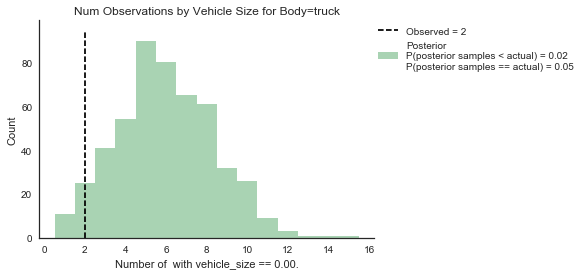

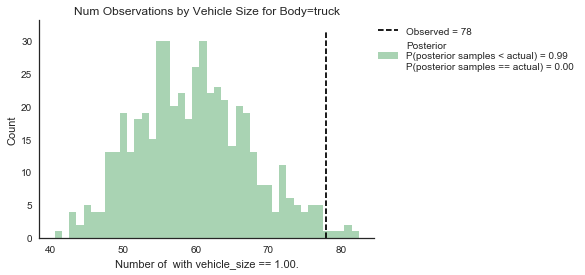

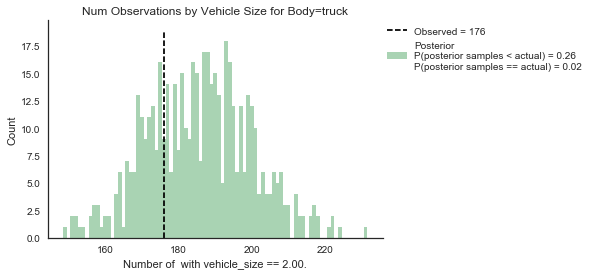

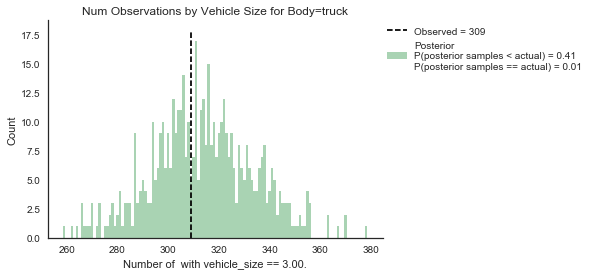

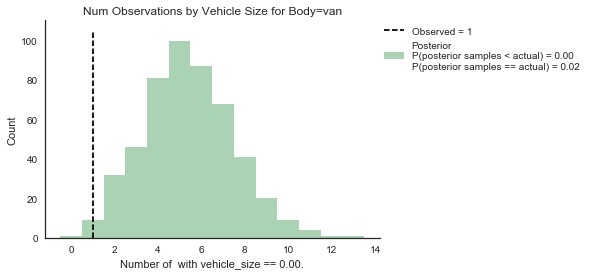

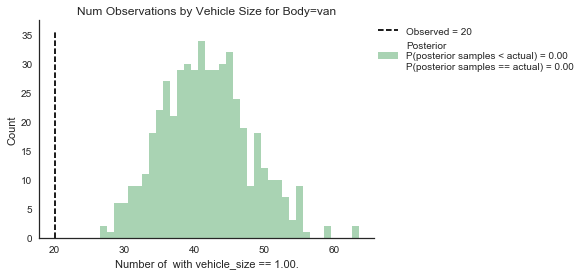

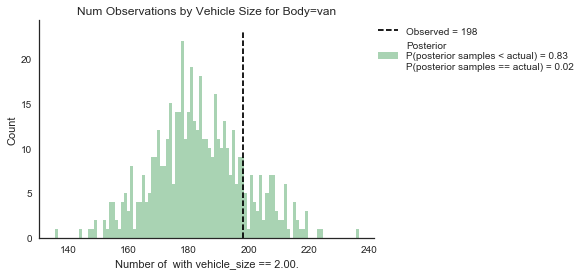

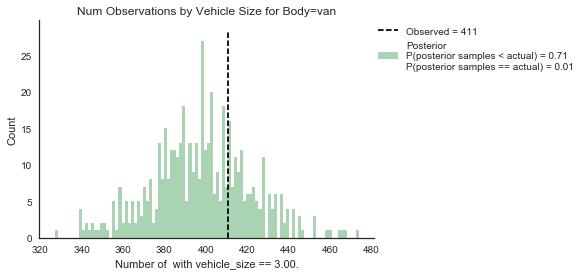

In [27]:
# Check the price variable for all of the various modes.
for body in np.sort(car_df.body_type.unique()):
    filter_row = car_df.body_type == body
    current_title = 'Num Observations by Vehicle Size for Body={}'

    viz.plot_categorical_predictive_densities(
        car_df,
        None,
        likelihood_sim_y,
        'vehicle_size',
        filter_row,
        car_mnl.choices,
        title=current_title.format(body))

What we can see is that we systematically:
1. under predict regular cars with vehicle size = 0
2. under predict sports cars with vehicle size = 0
3. over predict sports cars with vehicle size = 3
4. over predict sports utility vehicle with vehicle size = 0
5. under predict sports utility vehicle with vehicle size = 3
6. over predict trucks with vehicle size = 0
7. under predict trucks with vehicle size = 1
8. over predict vans with vehicle size = 0
9. over predict vans with vehicle size = 1

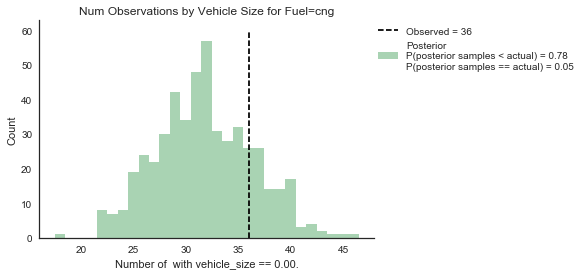

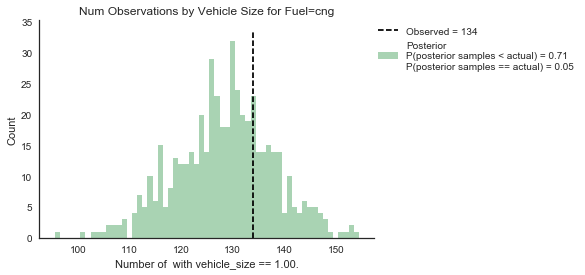

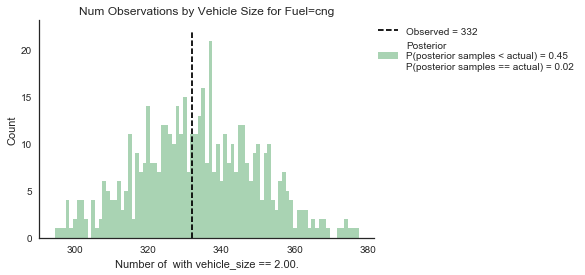

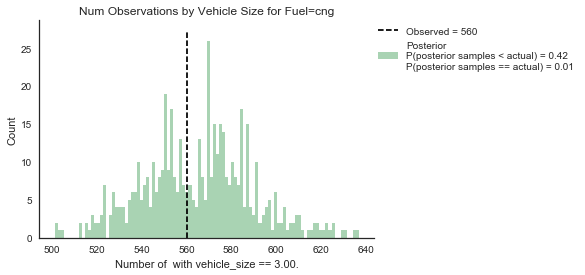

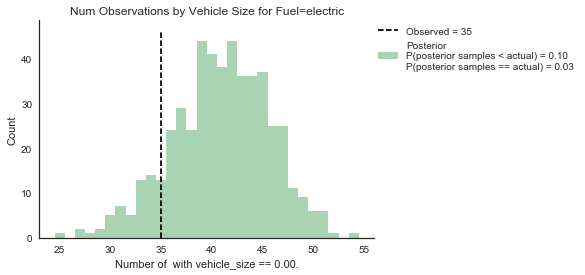

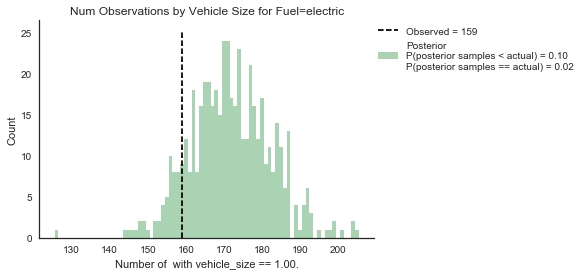

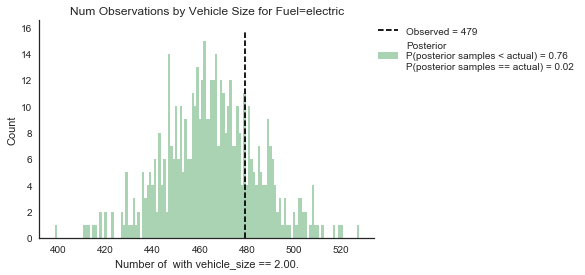

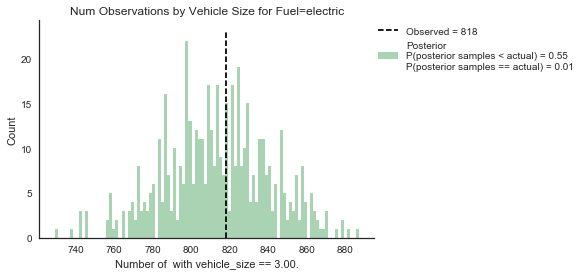

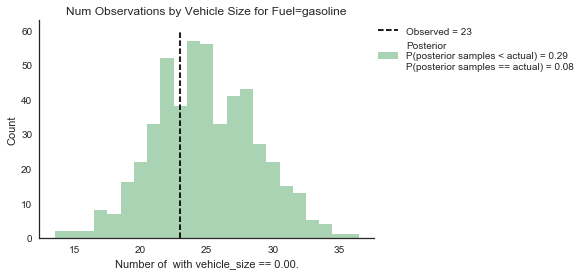

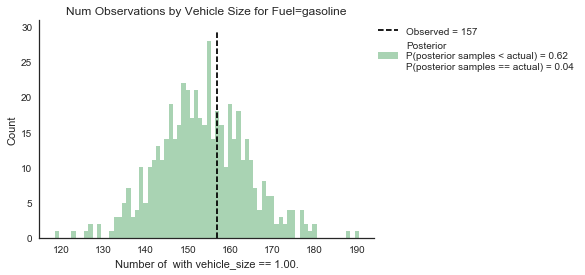

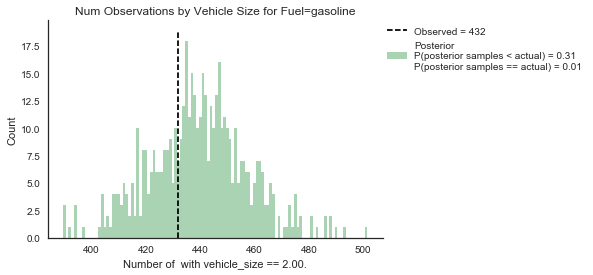

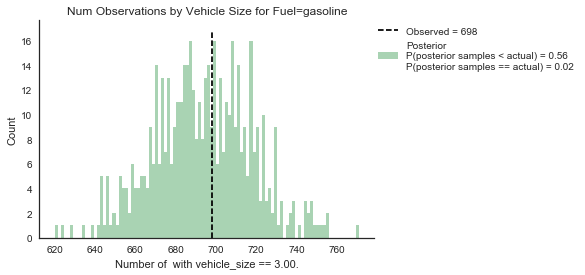

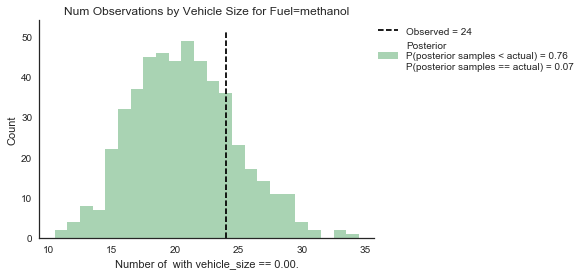

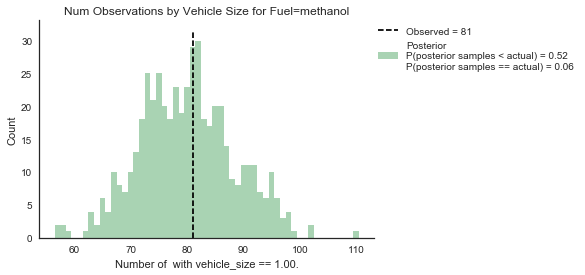

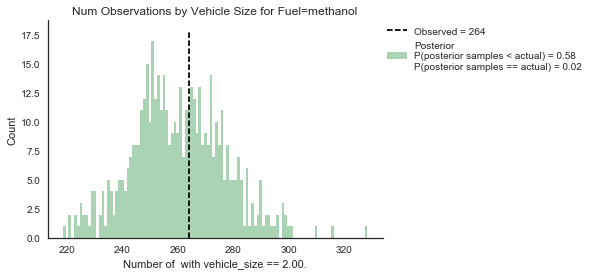

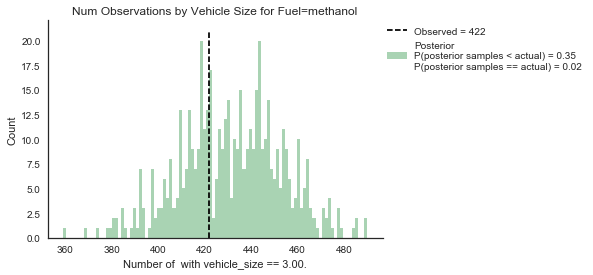

In [28]:
# Check the price variable for all of the various modes.
for fuel in np.sort(car_df.fuel_type.unique()):
    filter_row = car_df.fuel_type == fuel
    current_title = 'Num Observations by Vehicle Size for Fuel={}'

    viz.plot_categorical_predictive_densities(
        car_df,
        None,
        likelihood_sim_y,
        'vehicle_size',
        filter_row,
        car_mnl.choices,
        title=current_title.format(fuel))

From the plots above, we can see that our model systematically over-predicts electric vehicles of size 0 (and to a lesser extent, of size 1).

## Luggage Space

In [29]:
car_df.loc[car_df.choice == 1, 'luggage_space'].value_counts()

1.0    3771
0.7     883
Name: luggage_space, dtype: int64

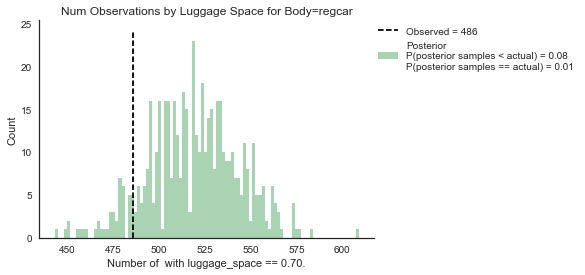

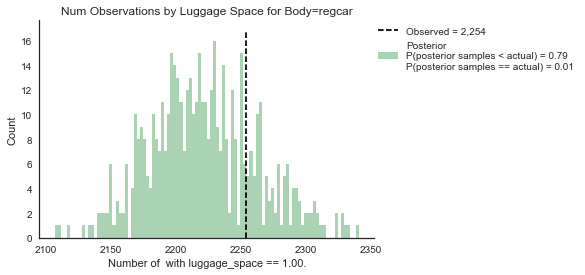

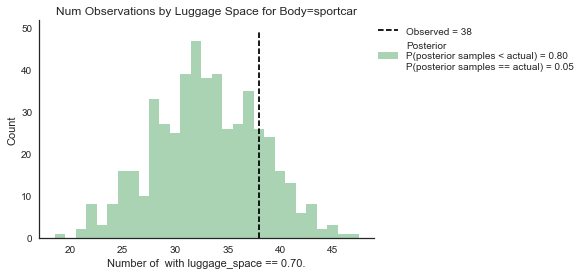

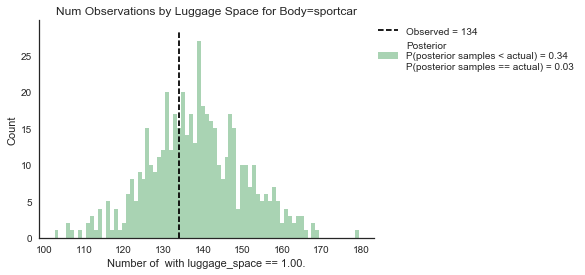

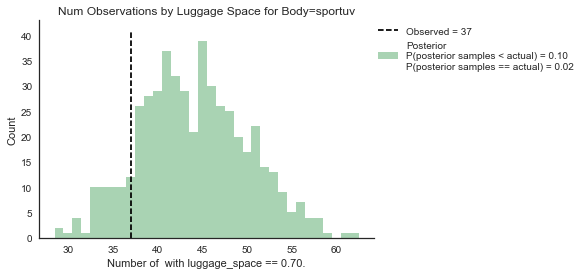

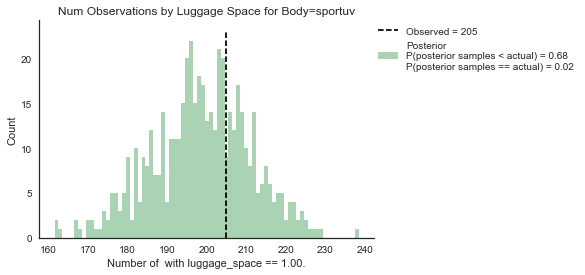

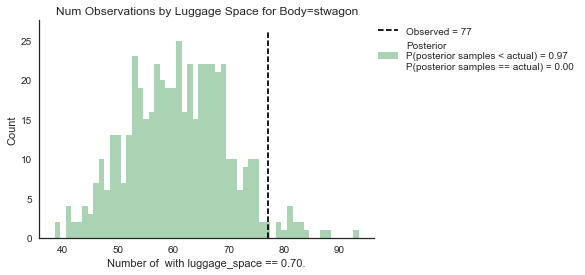

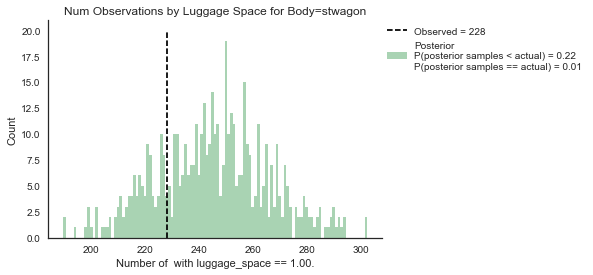

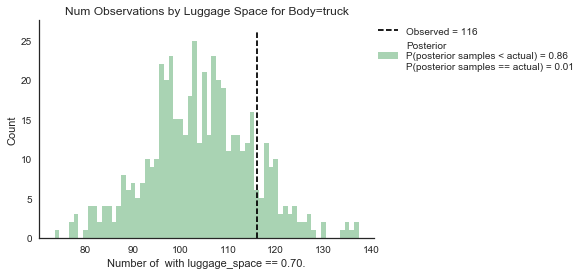

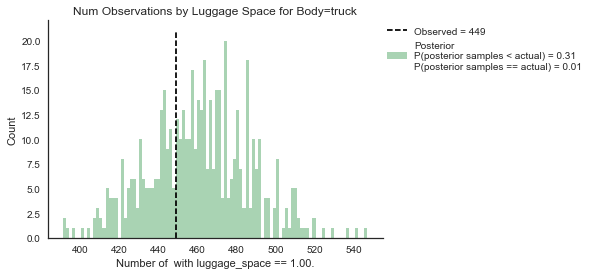

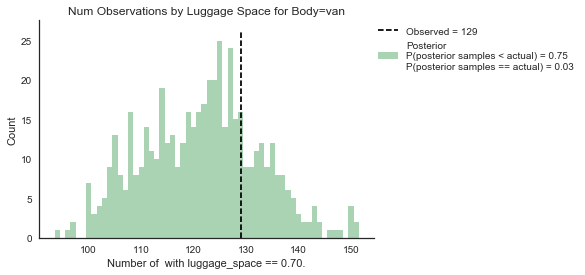

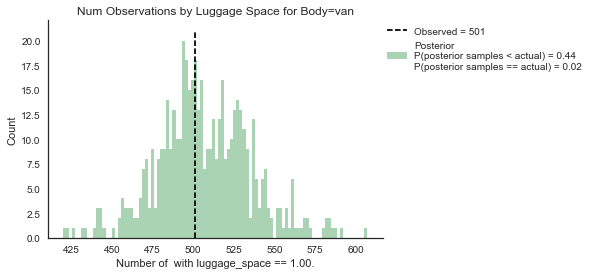

In [30]:
# Check the price variable for all of the various modes.
for body in np.sort(car_df.body_type.unique()):
    filter_row = car_df.body_type == body
    current_title = 'Num Observations by Luggage Space for Body={}'

    viz.plot_categorical_predictive_densities(
        car_df,
        None,
        likelihood_sim_y,
        'luggage_space',
        filter_row,
        car_mnl.choices,
        title=current_title.format(body))

We can see that we systematically:

1. under predict regular cars with luggage space = 0.7
2. under predict station wagons with luggage space = 0.7


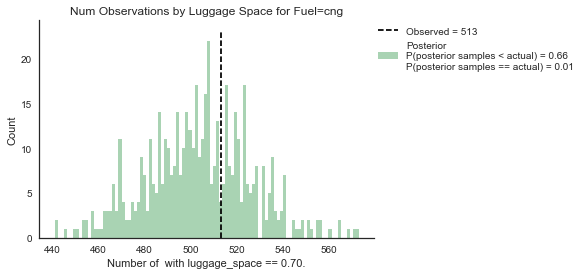

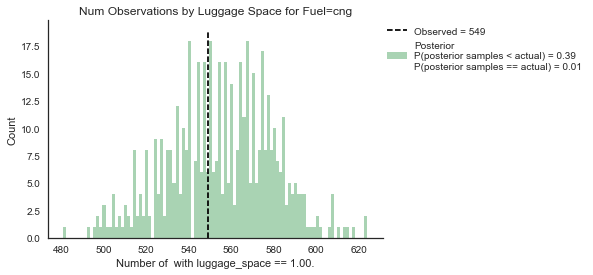

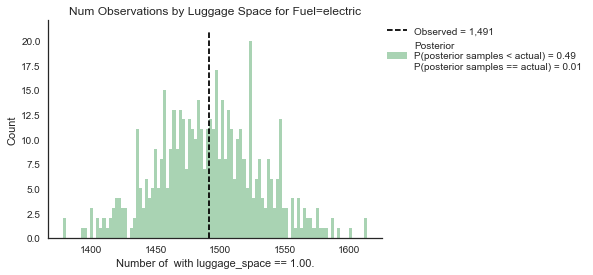

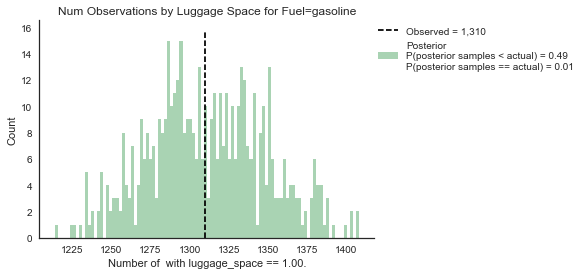

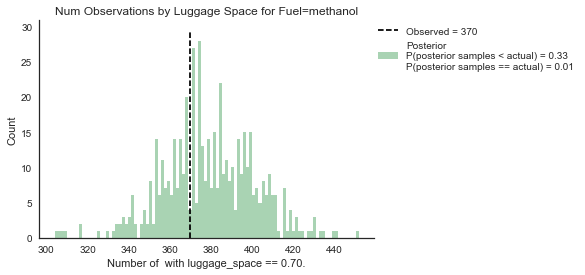

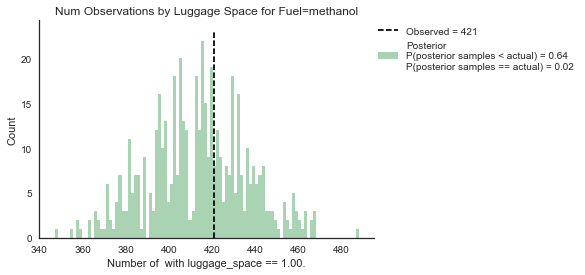

In [31]:
# Check the price variable for all of the various modes.
for fuel in np.sort(car_df.fuel_type.unique()):
    filter_row = car_df.fuel_type == fuel
    current_title = 'Num Observations by Luggage Space for Fuel={}'

    viz.plot_categorical_predictive_densities(
        car_df,
        None,
        likelihood_sim_y,
        'luggage_space',
        filter_row,
        car_mnl.choices,
        title=current_title.format(fuel))

With respect to vehicle fuel type, the observed distribution of luggage space seems adequately captured.

# Operating Cost

In [32]:
car_df.loc[car_df.choice == 1, 'cents_per_mile'].value_counts()

2    1420
4    1206
8     984
6     844
1     200
Name: cents_per_mile, dtype: int64

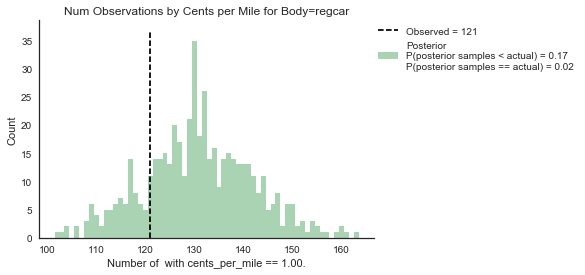

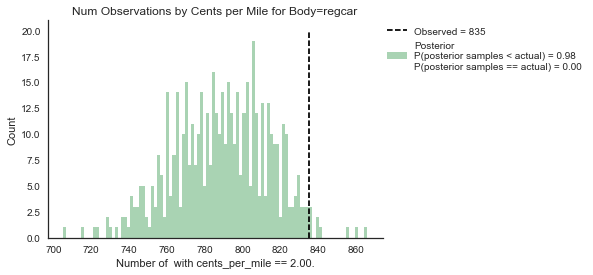

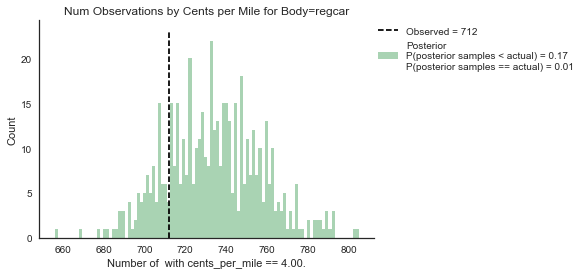

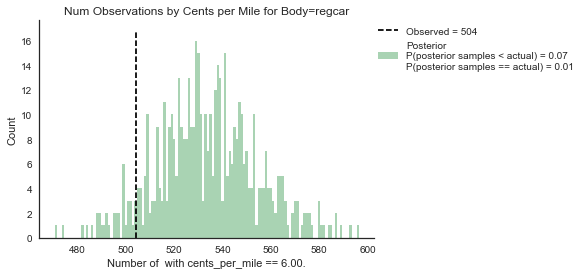

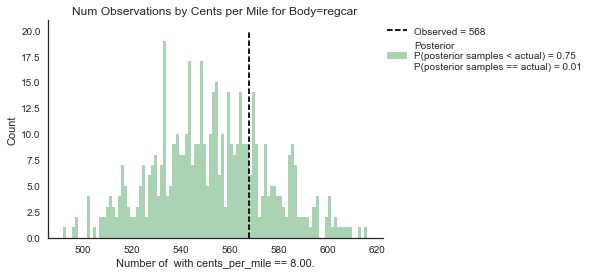

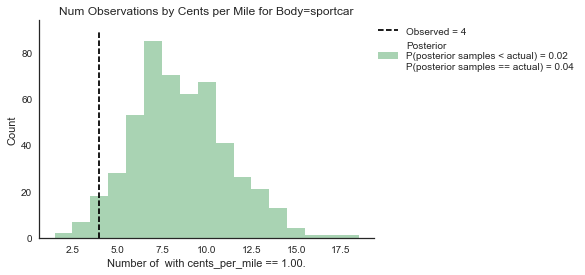

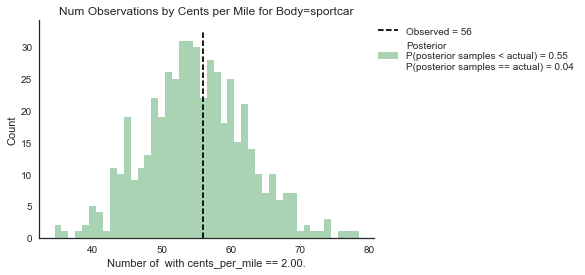

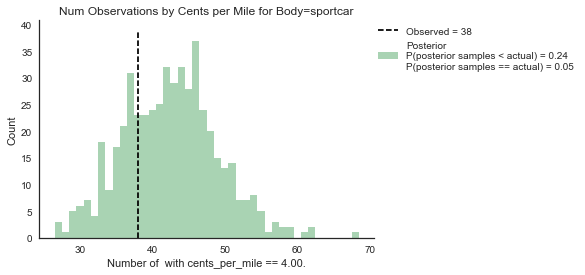

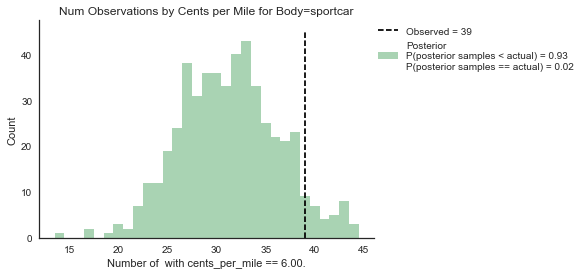

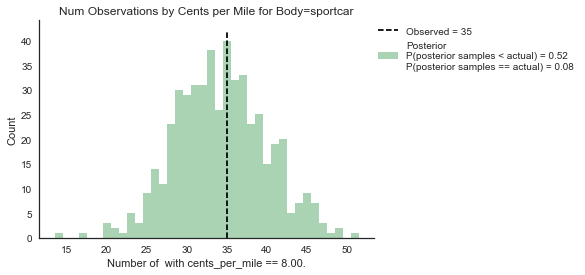

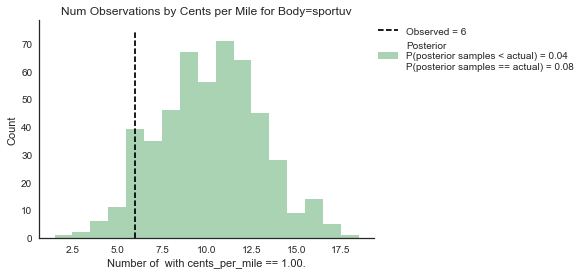

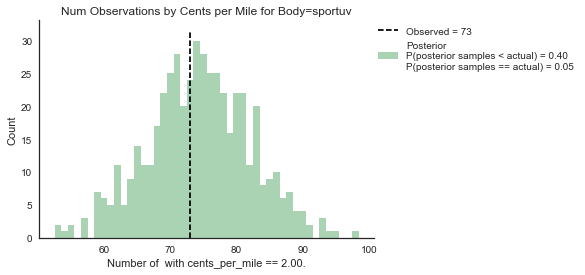

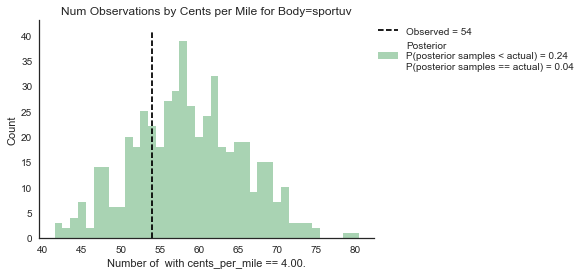

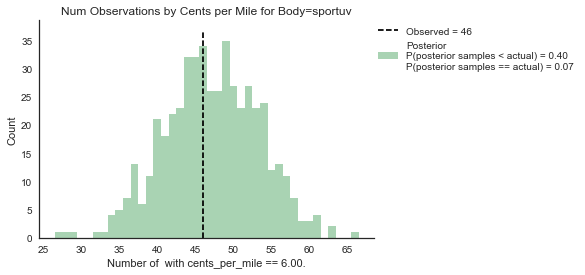

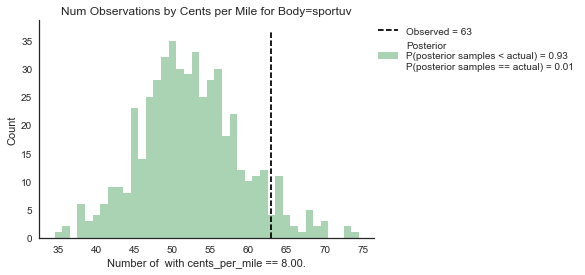

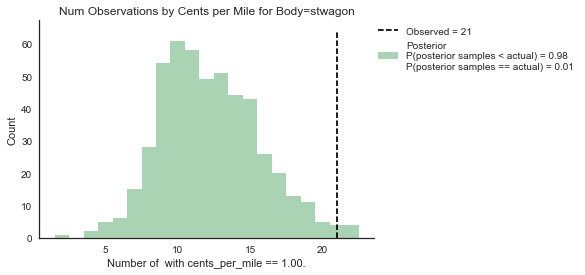

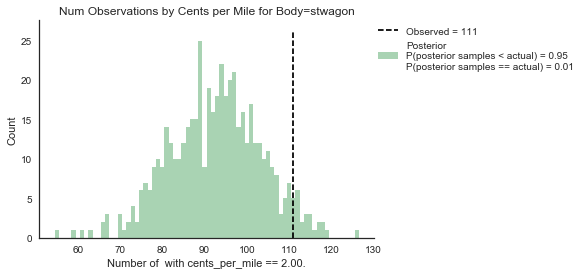

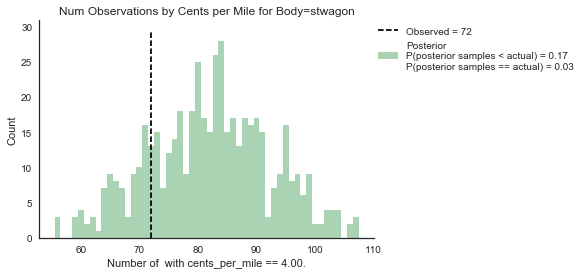

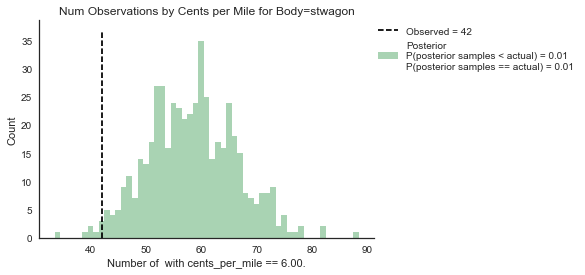

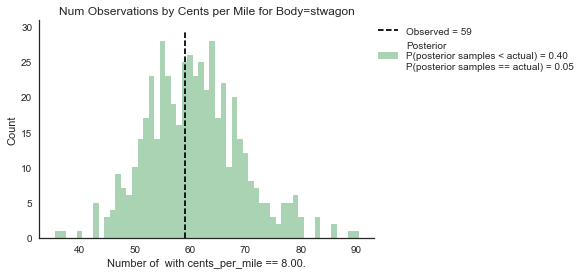

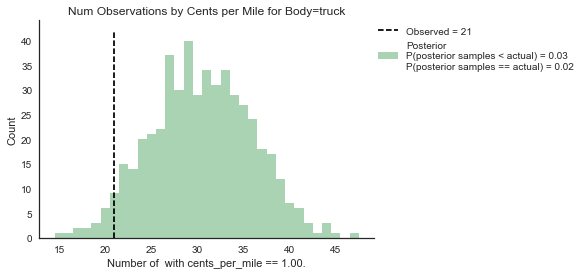

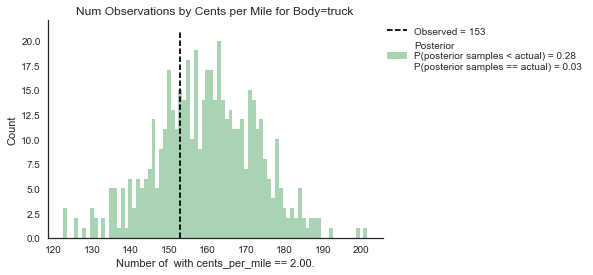

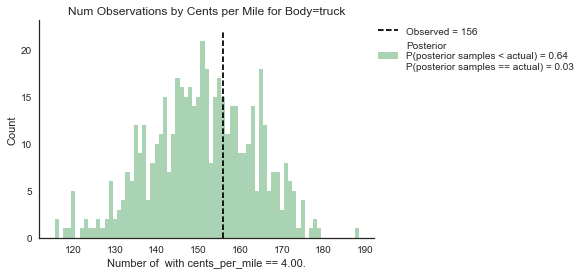

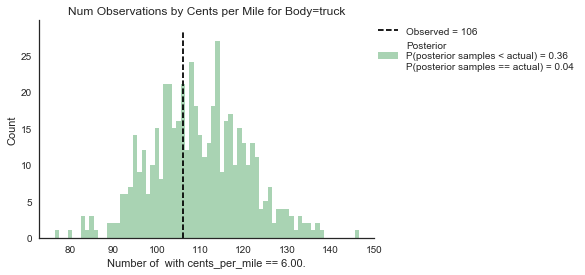

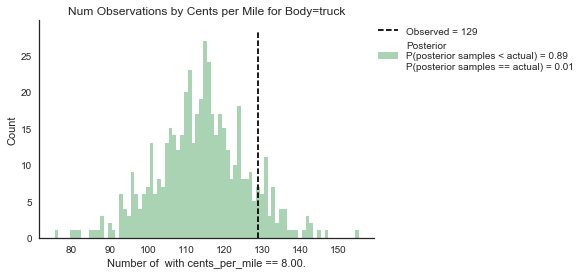

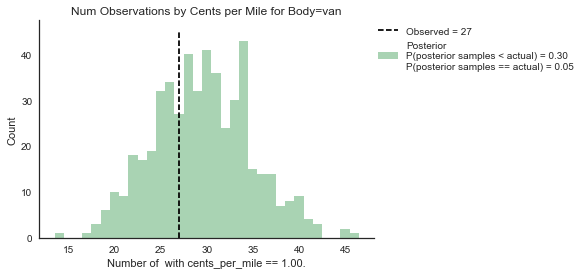

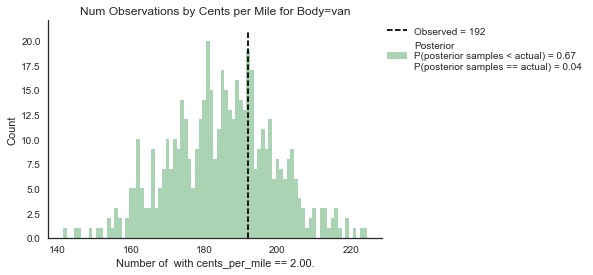

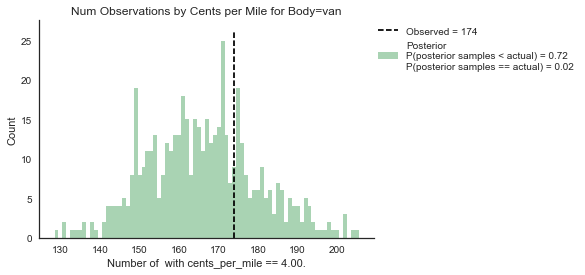

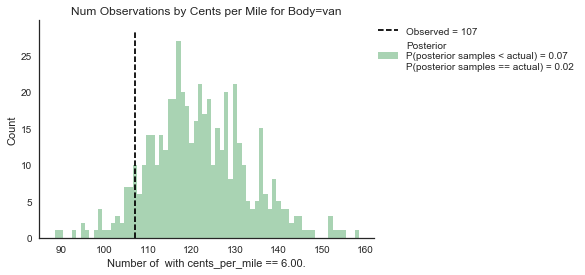

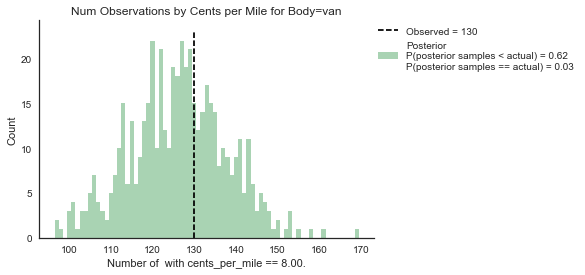

In [33]:
# Check the price variable for all of the various modes.
for body in np.sort(car_df.body_type.unique()):
    filter_row = car_df.body_type == body
    current_title = 'Num Observations by Cents per Mile for Body={}'

    viz.plot_categorical_predictive_densities(
        car_df,
        None,
        likelihood_sim_y,
        'cents_per_mile',
        filter_row,
        car_mnl.choices,
        title=current_title.format(body))

From the plots above, we see that the model systematically:
1. under predict regular car with cents_per_mile = 2
2. over predict regular car with cents_per_mile = 6
3. over predict sports car with cents_per_mile = 1
4. under predict sports car with cents_per_mile = 6
5. over predict sports utility vehicle with cents per mile = 1
6. under predict sports utility vehicle with cents per mile = 8
7. under predict station wagon with cents per mile = 1
8. under predict station wagon with cents per mile = 2
9. over predict station wagon with cents per mile = 6
10. over predict truck with cents per mile = 1

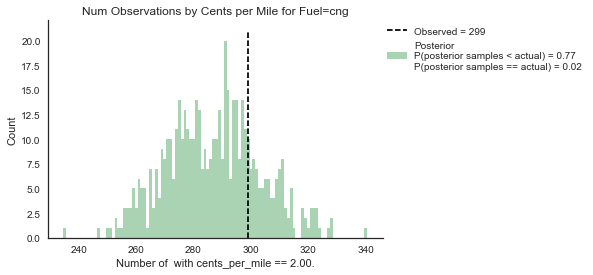

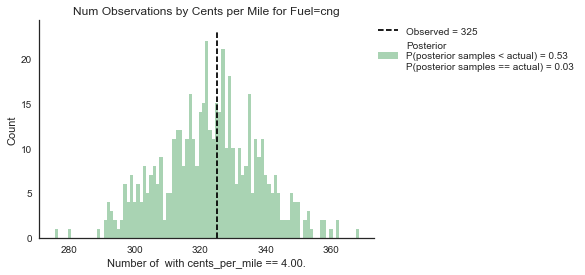

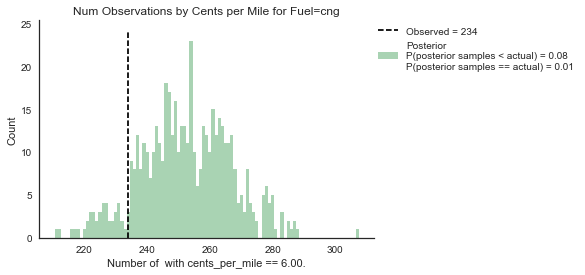

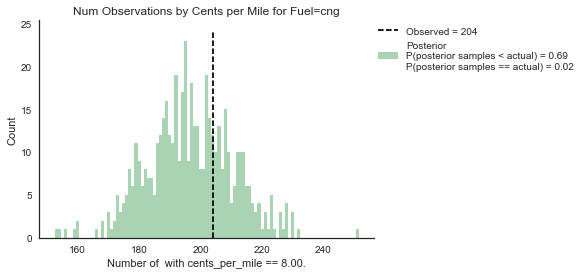

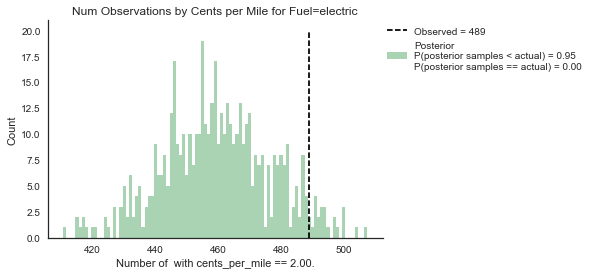

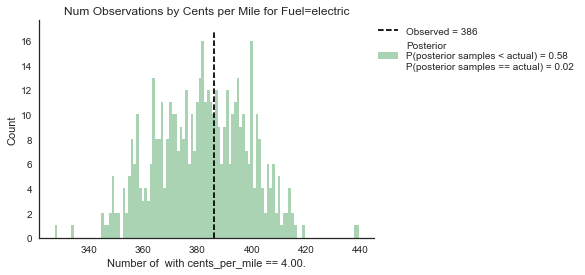

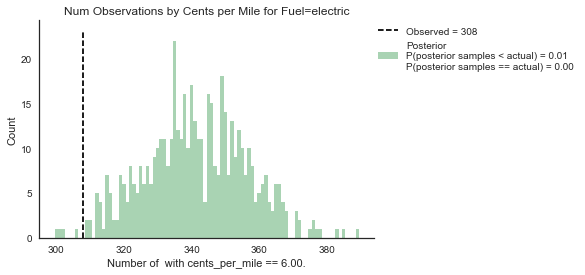

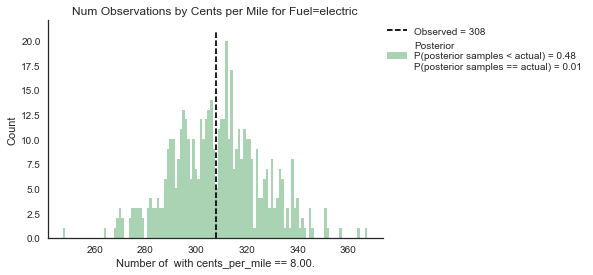

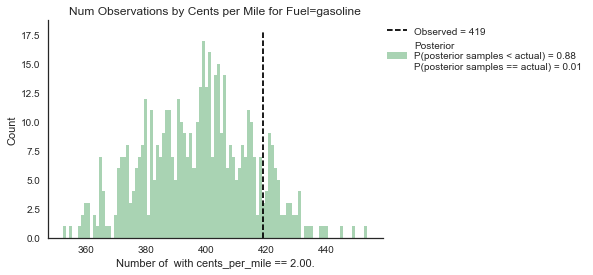

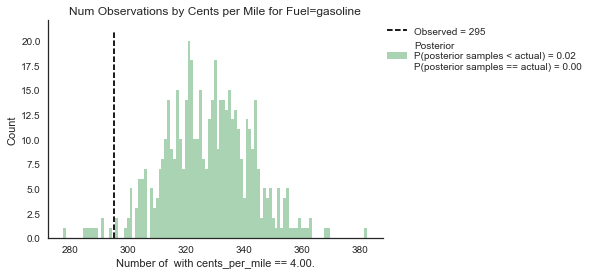

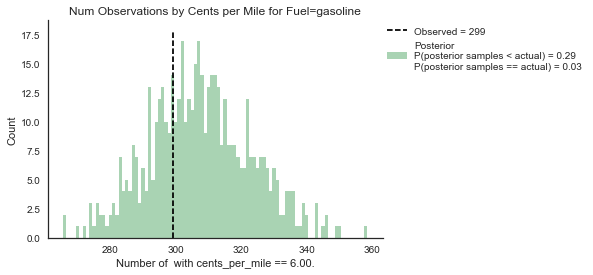

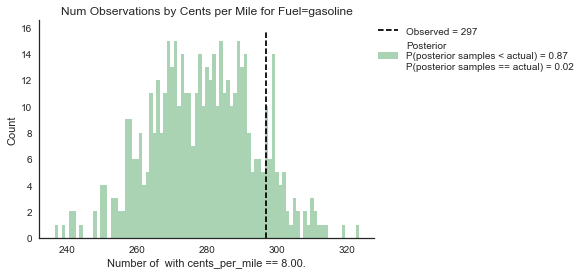

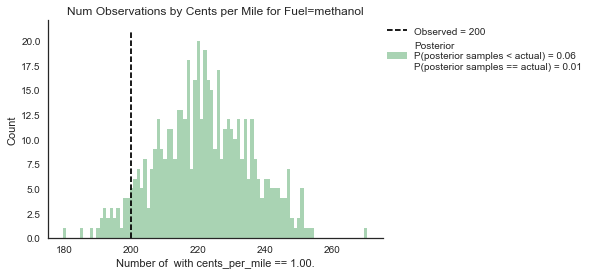

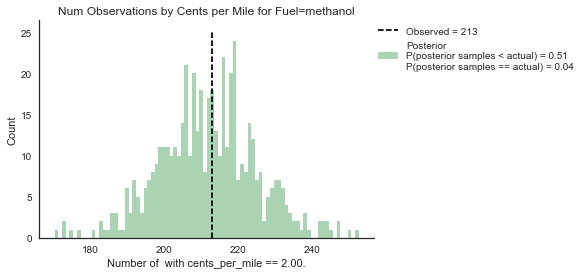

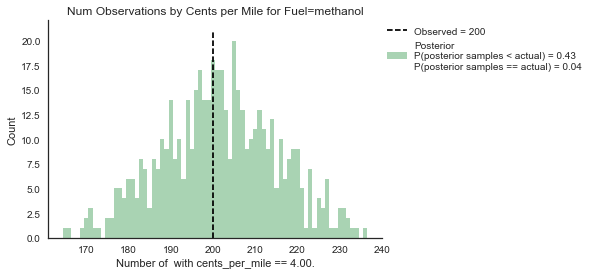

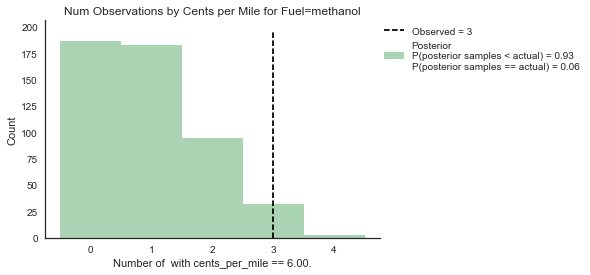

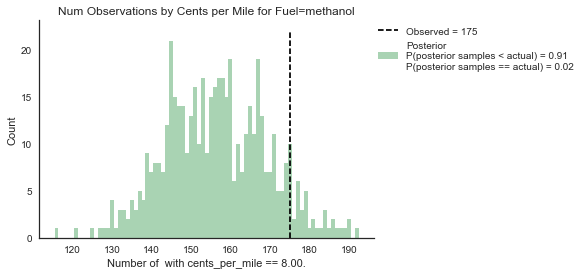

In [34]:
# Check the price variable for all of the various modes.
for fuel in np.sort(car_df.fuel_type.unique()):
    filter_row = car_df.fuel_type == fuel
    current_title = 'Num Observations by Cents per Mile for Fuel={}'

    viz.plot_categorical_predictive_densities(
        car_df,
        None,
        likelihood_sim_y,
        'cents_per_mile',
        filter_row,
        car_mnl.choices,
        title=current_title.format(fuel))

From the plots above, we see that the model systematically:
1. under predict electric vehicles with cents_per_mile = 2
2. over predict electric vehicles with cents_per_mile = 6
3. over predict gas vehicles with cents_per_mile = 4
4. under predict gas vehicles with cents_per_mile = 8
5. over predict methanol vehicles with cents per mile = 1
6. under predict methanol vehicles with cents per mile = 6
7. under predict methanol vehicles with cents per mile = 8